In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Project Introduction**

The objective here is to create a predictive Machine Learning model that is able to predict the results of civilian complaints filed against NYPD police officers. The data we're analyzing is from the Civilian Compliant Review Board (CCRB). We also have geospatial data about the police precincts. We intend to improve and aid CCRB with their investigation of these complaints so they they can prioritize complaints. This would also strengthen the public faith and confidence and increase the overall safety and harmony of New York.

[Github Link](https://github.com/amanlaiq/Complaint-Outcome-Prediction)

# **Data Overview**

We have gathered two key datasets to support our research and analysis. Below is a detailed breakdown of each dataset:

## 1. CCRB Dataset

### Dataset Source
- **Origin:** Civilian Complaint Review Board (CCRB)

### Timeframe of Data
- **Period:** 1985 - 2020

### Volume of Data
- **Total Complaints:** 33,358

### Dataset Composition
- The CCRB dataset is provided as a primary `.csv` file, along with an Excel file named `CCRB Data Layout Table`, which serves to clarify the terminology used within the dataset.

## 2. Additional Geospatial Data

This dataset complements the first by providing geospatial information crucial for in-depth analysis and visualization.

### Dataset Composition
- A shapefile dataset (`*.shp`) is included to facilitate precinct geolocation analysis, enhancing the exploratory data analysis (EDA) process.

### Accessibility
- The dataset, along with the `.csv` file and the Excel terminology guide, is accessible through a provided link.
- Precinct location data is derived from an exported shapefile (`.shp`), allowing for precise geographical mapping and analysis.

### Utilization
- This geospatial dataset is pivotal for uncovering patterns and trends within the civilian complaints filed against NYPD officers. It enables a spatial analysis approach, augmenting the predictive modeling of outcomes and fostering a deeper understanding of the impact of precinct locations on complaint frequencies and types.



In [ ]:
# navigating to the dataset folder uploaded to google drive
%cd "/content/drive/MyDrive/PoliceComplaintDataset"
!pwd

/content/drive/MyDrive/PoliceComplaintDataset
/content/drive/MyDrive/PoliceComplaintDataset


In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import random
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import geopandas as gpd
from matplotlib import pyplot
from geopy.geocoders import Nominatim
import datetime

In [ ]:
df=pd.read_csv("allegations_202007271729.csv")
df.shape

(33358, 27)

In [ ]:
df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33358 entries, 0 to 33357
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   unique_mos_id             33358 non-null  int64  
 1   first_name                33358 non-null  object 
 2   last_name                 33358 non-null  object 
 3   command_now               33358 non-null  object 
 4   shield_no                 33358 non-null  int64  
 5   complaint_id              33358 non-null  int64  
 6   month_received            33358 non-null  int64  
 7   year_received             33358 non-null  int64  
 8   month_closed              33358 non-null  int64  
 9   year_closed               33358 non-null  int64  
 10  command_at_incident       31814 non-null  object 
 11  rank_abbrev_incident      33358 non-null  object 
 12  rank_abbrev_now           33358 non-null  object 
 13  rank_now                  33358 non-null  object 
 14  rank_i

In [ ]:
df.describe()

,unique_mos_id,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,mos_age_incident,complainant_age_incident,precinct
count,33358.000000,33358.000000,33358.000000,33358.000000,33358.000000,33358.000000,33358.000000,33358.000000,28546.000000,33334.000000
mean,18169.912495,6451.608819,23905.058217,6.323551,2010.726782,6.470772,2011.525661,32.346873,32.484201,64.365213
std,9566.316896,7945.641596,11954.434138,3.362951,6.034725,3.343372,6.085907,6.040944,28.408963,31.451592
min,2.000000,0.000000,517.000000,1.000000,1985.000000,1.000000,1985.000000,20.000000,-4301.000000,0.000000
25%,9671.000000,1089.000000,13684.750000,3.000000,2007.000000,4.000000,2008.000000,28.000000,23.000000,43.000000
50%,19215.000000,3691.000000,25132.000000,6.000000,2012.000000,6.000000,2013.000000,31.000000,30.000000,67.000000
75%,25412.000000,7155.000000,34252.000000,9.000000,2016.000000,9.000000,2016.000000,36.000000,41.000000,81.000000
max,36374.000000,31977.000000,43703.000000,12.000000,2020.000000,12.000000,2020.000000,60.000000,101.000000,1000.000000


In [ ]:
df.columns

Index(['unique_mos_id', 'first_name', 'last_name', 'command_now', 'shield_no',
       'complaint_id', 'month_received', 'year_received', 'month_closed',
       'year_closed', 'command_at_incident', 'rank_abbrev_incident',
       'rank_abbrev_now', 'rank_now', 'rank_incident', 'mos_ethnicity',
       'mos_gender', 'mos_age_incident', 'complainant_ethnicity',
       'complainant_gender', 'complainant_age_incident', 'fado_type',
       'allegation', 'precinct', 'contact_reason', 'outcome_description',
       'board_disposition'],
      dtype='object')

In [ ]:
df.isna().sum()

unique_mos_id                  0
first_name                     0
last_name                      0
command_now                    0
shield_no                      0
complaint_id                   0
month_received                 0
year_received                  0
month_closed                   0
year_closed                    0
command_at_incident         1544
rank_abbrev_incident           0
rank_abbrev_now                0
rank_now                       0
rank_incident                  0
mos_ethnicity                  0
mos_gender                     0
mos_age_incident               0
complainant_ethnicity       4464
complainant_gender          4195
complainant_age_incident    4812
fado_type                      0
allegation                     1
precinct                      24
contact_reason               199
outcome_description           56
board_disposition              0
dtype: int64

# **Merging base dataset with latitude and longitude dataset**

In [ ]:
location= gpd.read_file("geo_export_359d6e65-21a5-4212-a07f-e715385fc5bc.shp")
location = location.to_crs(4326)
location['longitude'] = location.centroid.x
location['latitude'] = location.centroid.y
df=df.merge(location, how='right', on='precinct')

<ipython-input-150-2ee30262bf62>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location['longitude'] = location.centroid.x
<ipython-input-150-2ee30262bf62>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location['latitude'] = location.centroid.y


# **Adding an additional column and binning from data received and date closed**

In [ ]:
df['date_received'] = pd.to_datetime(df['year_received'].astype(str) + '-' +
                                     df['month_received'].astype(str) + '-01')
df['date_closed'] = pd.to_datetime(df['year_closed'].astype(str) + '-' +
                                   df['month_closed'].astype(str) + '-01')
df['days_taken_to_resolve']=(df['date_closed']-df['date_received']).dt.days
df['bins_day']=np.floor(df['days_taken_to_resolve']/30)

In [ ]:
df[['days_taken_to_resolve','bins_day']]

,days_taken_to_resolve,bins_day
0,305,10.0
1,305,10.0
2,151,5.0
3,151,5.0
4,183,6.0
...,...,...
33305,122,4.0
33306,153,5.0
33307,181,6.0
33308,334,11.0


In [ ]:
df.columns

Index(['unique_mos_id', 'first_name', 'last_name', 'command_now', 'shield_no',
       'complaint_id', 'month_received', 'year_received', 'month_closed',
       'year_closed', 'command_at_incident', 'rank_abbrev_incident',
       'rank_abbrev_now', 'rank_now', 'rank_incident', 'mos_ethnicity',
       'mos_gender', 'mos_age_incident', 'complainant_ethnicity',
       'complainant_gender', 'complainant_age_incident', 'fado_type',
       'allegation', 'precinct', 'contact_reason', 'outcome_description',
       'board_disposition', 'shape_area', 'shape_leng', 'geometry',
       'longitude', 'latitude', 'date_received', 'date_closed',
       'days_taken_to_resolve', 'bins_day'],
      dtype='object')

# **Preparing new dataset for EDA after merging with the location dataset**

In [ ]:
import geopy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderInsufficientPrivileges

graph_data = df.groupby(['precinct']).size().reset_index(name='frequency')
merged_data = location.merge(graph_data, how='right', on='precinct')
merged_data['latitude']=merged_data['latitude'].apply(str)
merged_data['longitude']=merged_data['longitude'].apply(str)
geolocator = Nominatim(user_agent="geoapiExercises")



In [ ]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderUnavailable, GeocoderTimedOut, GeocoderServiceError
import time

geolocator = Nominatim(user_agent="nypd", timeout=10)

def zipcode_of_location(row):
    location_str = f"{row['latitude']},{row['longitude']}"
    retries = 3
    for attempt in range(retries):
        try:
            location = geolocator.reverse(location_str)
            zipcode = location.raw.get('address', {}).get('postcode', '')
            return zipcode
        except (GeocoderTimedOut, GeocoderUnavailable) as e:
            print(f"Retrying... Attempt {attempt + 1} of {retries}")
            time.sleep(1)
        except Exception as e:
            print(f"Error: {e}")
            return None
    return None

merged_data['zipcode'] = merged_data.apply(zipcode_of_location, axis=1)
merged_data_sorted = merged_data.sort_values('frequency', ascending=False)
merged_data_sorted = merged_data_sorted.head()

In [ ]:
merged_data_sorted

,precinct,shape_area,shape_leng,geometry,longitude,latitude,frequency,zipcode
46,75.0,1.804941e+08,106337.879200,"MULTIPOLYGON (((-73.85023 40.62332, -73.85023 ...",-73.87775660857048,40.665009662366174,2172,11208
45,73.0,5.175437e+07,33000.209960,"POLYGON ((-73.90405 40.67922, -73.90349 40.678...",-73.91094655789068,40.6681587790829,1163,11212
26,44.0,5.551179e+07,31464.134787,"POLYGON ((-73.90269 40.84458, -73.90271 40.844...",-73.9207952796168,40.83380611153094,1139,10452
28,46.0,3.833342e+07,29392.712842,"POLYGON ((-73.89138 40.86170, -73.89142 40.861...",-73.90957642771251,40.852746440383804,1120,10453
39,67.0,9.381497e+07,43255.869527,"POLYGON ((-73.90755 40.65119, -73.90849 40.650...",-73.93381756632431,40.64804204405852,1119,11203


# **Abbreviations**

In [ ]:
xls = pd.ExcelFile('CCRB Data Layout Table.xlsx')
df_ranks = pd.read_excel(xls, 'Rank Abbrevs')
df_command = pd.read_excel(xls, 'Command Abbrevs')

In [ ]:
rank_dict=dict(zip(df_ranks.Abbreviation,df_ranks.Rank))
command_dict=dict(zip(df_command.Abbreviation,df_command['Command Name']))

In [ ]:
df['command_now'].value_counts()

command_now
INT CIS    1412
WARRSEC    1158
NARCBBX     692
DB CEIS     681
075 PCT     415
           ... 
C A B         1
CD IRS        1
PB HRD        1
C/PRV D       1
TRN BUR       1
Name: count, Length: 415, dtype: int64

In [ ]:
df['rank_abbrev_incident'].value_counts()

rank_abbrev_incident
POM    19799
SGT     5698
DT3     2697
POF     1397
PO      1288
LT      1262
DTS      329
DT2      193
CPT      182
SDS      128
SSA      105
DI        96
DET       50
INS       27
LSA       24
DT1       20
LCD       13
DC         2
Name: count, dtype: int64

In [ ]:
df['command_now'] = df['command_now'].map(command_dict)
df['command_at_incident'] = df['command_at_incident'].map(command_dict)

df['rank_abbrev_incident'] = df['rank_abbrev_incident'].map(rank_dict)
df['rank_abbrev_now'] = df['rank_abbrev_now'].map(rank_dict)

In [ ]:
df['command_now'].value_counts()

command_now
Criminal Intelligence Section                       1412
Warrant Section                                     1158
Narcotics Borough Bronx                              692
Organized Crime Investigation Division               681
075 Precinct                                         415
                                                    ... 
Facilities Management Division                         2
Chief of Department Investigation Review Section       1
Emergency Operations Center                            1
Crime Prevention Division                              1
Community Affairs Bureau                               1
Name: count, Length: 385, dtype: int64

In [ ]:
df['rank_abbrev_incident'].value_counts()

rank_abbrev_incident
Police Officer                    22484
Sergeant                           5698
Detective Grade 3                  2697
Lieutenant                         1262
Detective Specialist                329
Detective Grade 2                   193
Captain                             182
Sergeant Detective Squad            128
Sergeant Special Assignment         105
Deputy Inspector                     96
Inspector                            27
Lieutenant Special Assignment        24
Detective Grade 1                    20
Lieutenant Commander Detective       13
Deputy Chief                          2
Name: count, dtype: int64

# **Dropping Columns**

In [ ]:
df.drop(['rank_now','rank_incident','shield_no'],axis=1,inplace=True)

# **Removing NAs with number of rows < 200**

In [ ]:
df.dropna(subset=['allegation','precinct','contact_reason','outcome_description'],axis=0,inplace=True,how='any')

# **Combining some categories and filling NAs with mean, percentile_random_value, and mode value**

In [ ]:
df["complainant_ethnicity"]=np.where(
    ((df["complainant_ethnicity"]=="Unknown") | (df["complainant_ethnicity"]=="Other Race") | (df["complainant_ethnicity"]=="Refused")),
    "Not disclosed",
    df["complainant_ethnicity"]
)
df.complainant_ethnicity.value_counts()

complainant_ethnicity
Black              17011
Hispanic            6384
White               2754
Not disclosed       1957
Asian                527
American Indian       63
Name: count, dtype: int64

In [ ]:
df['complainant_gender'].value_counts()

complainant_gender
Male                     23904
Female                    4969
Not described               57
Transwoman (MTF)            20
Transman (FTM)               5
Gender non-conforming        2
Name: count, dtype: int64

In [ ]:
df['complainant_gender']=np.where(
    df['complainant_gender'].isna(),
    df['complainant_gender'].value_counts().index[0],
    df['complainant_gender']
)
df['complainant_gender'].value_counts()

complainant_gender
Male                     28005
Female                    4969
Not described               57
Transwoman (MTF)            20
Transman (FTM)               5
Gender non-conforming        2
Name: count, dtype: int64

In [ ]:
df['command_at_incident'].value_counts()

command_at_incident
075 Precinct                                 1360
046 Precinct                                  824
044 Precinct                                  754
Narcotics Borough Brooklyn North              746
079 Precinct                                  735
                                             ... 
Applicant Processing Division                   1
048 Detective Squad                             1
060 Precinct                                    1
Detective Borough Queens South Operations       1
122 Detective Squad                             1
Name: count, Length: 271, dtype: int64

In [ ]:
top5_commands=df['command_at_incident'].value_counts(normalize=True)[0:5].index.to_list()
top5_commands_weights=df['command_at_incident'].value_counts(normalize=True)[0:5].to_list()
top5_commands_weights=list(normalize([top5_commands_weights],norm="l1")[0])
print(top5_commands)
print(top5_commands_weights)

['075 Precinct', '046 Precinct', '044 Precinct', 'Narcotics Borough Brooklyn North', '079 Precinct']
[0.30776193708983934, 0.18646752658972618, 0.17062683865127856, 0.16881647431545596, 0.16632722335369993]


In [ ]:
randomSampleList = np.random.choice(top5_commands,df['command_at_incident'].isna().sum(),replace=True,p=top5_commands_weights)
df['command_at_incident'].fillna(pd.Series(randomSampleList,index=df['command_at_incident'].index
                                           [df['command_at_incident'].isna()]), inplace=True)

In [ ]:
df['command_at_incident'].value_counts()

command_at_incident
075 Precinct                        2302
046 Precinct                        1406
044 Precinct                        1268
079 Precinct                        1228
Narcotics Borough Brooklyn North    1214
                                    ... 
Emergency Service Squad 06             1
084 Detective Squad                    1
OMAP                                   1
Gang Division                          1
122 Detective Squad                    1
Name: count, Length: 271, dtype: int64

# **Combining column and dropping original columns**

In [ ]:
df['name']=df['first_name']+" "+df['last_name']
df.drop(['first_name','last_name'],axis=1,inplace=True)

In [ ]:
df.head()

,unique_mos_id,command_now,complaint_id,month_received,year_received,month_closed,year_closed,command_at_incident,rank_abbrev_incident,rank_abbrev_now,...,shape_area,shape_leng,geometry,longitude,latitude,date_received,date_closed,days_taken_to_resolve,bins_day,name
0,10134,079 Precinct,24367,10,2011,8,2012,001 Precinct,Police Officer,Lieutenant,...,4.728642e+07,80283.538778,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-74.012069,40.709791,2011-10-01,2012-08-01,305,10.0,James Hart
1,10134,079 Precinct,24367,10,2011,8,2012,001 Precinct,Police Officer,Lieutenant,...,4.728642e+07,80283.538778,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-74.012069,40.709791,2011-10-01,2012-08-01,305,10.0,James Hart
2,10134,079 Precinct,26826,10,2012,3,2013,001 Precinct,Police Officer,Lieutenant,...,4.728642e+07,80283.538778,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-74.012069,40.709791,2012-10-01,2013-03-01,151,5.0,James Hart
3,10134,079 Precinct,26826,10,2012,3,2013,001 Precinct,Police Officer,Lieutenant,...,4.728642e+07,80283.538778,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-74.012069,40.709791,2012-10-01,2013-03-01,151,5.0,James Hart
4,10134,079 Precinct,32585,4,2015,10,2015,001 Precinct,Police Officer,Lieutenant,...,4.728642e+07,80283.538778,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",-74.012069,40.709791,2015-04-01,2015-10-01,183,6.0,James Hart


In [ ]:
print(df.describe())

       unique_mos_id  complaint_id  month_received  year_received  \
count   33058.000000  33058.000000    33058.000000   33058.000000   
mean    18166.338466  23933.525380        6.322554    2010.749440   
min         2.000000    517.000000        1.000000    1985.000000   
25%      9671.000000  13788.000000        3.000000    2007.000000   
50%     19211.500000  25142.000000        6.000000    2012.000000   
75%     25412.000000  34222.000000        9.000000    2016.000000   
max     36374.000000  43703.000000       12.000000    2020.000000   
std      9564.189515  11898.461739        3.360411       5.997266   

       month_closed   year_closed  mos_age_incident  complainant_age_incident  \
count  33058.000000  33058.000000      33058.000000              28342.000000   
mean       6.475195   2011.548067         32.350596                 32.467433   
min        1.000000   1985.000000         20.000000              -4301.000000   
25%        4.000000   2008.000000         28.000000   

In [ ]:
ethnicity_contact_crosstab = pd.crosstab(df['contact_reason'], df['complainant_ethnicity'])
ethnicity_contact_crosstab

complainant_ethnicity,American Indian,Asian,Black,Hispanic,Not disclosed,White
contact_reason,,,,,,
Aided case,0,4,65,26,10,26
Arrest/Complainant,0,0,2,0,0,0
Assist ACS or other agency,0,0,27,0,1,0
C/V at PCT to file complaint of crime,0,0,46,28,7,16
C/V at PCT to obtain information,0,3,85,35,14,24
C/V at PCT to retrieve property,0,3,15,10,2,6
C/V intervened on behalf of/observed encounter w/3rd party,0,15,272,124,48,52
C/V requested info from officer,0,0,45,19,23,19
C/V requested investigation of crime,2,7,133,54,31,66


In [ ]:
ethnicity_outcome_crosstab = pd.crosstab(df['outcome_description'], df['complainant_ethnicity'])
ethnicity_outcome_crosstab

complainant_ethnicity,American Indian,Asian,Black,Hispanic,Not disclosed,White
outcome_description,,,,,,
Arrest - OGA,0,12,420,100,24,38
Arrest - assault (against a PO),0,8,546,139,46,75
Arrest - disorderly conduct,0,7,592,249,41,70
Arrest - harrassment (against a PO),0,0,8,0,3,1
Arrest - other violation/crime,8,121,5379,2128,629,668
Arrest - resisting arrest,0,25,888,373,95,111
Juvenile Report,0,0,35,6,15,0
Moving violation summons issued,2,54,389,149,50,159
No arrest made or summons issued,33,215,6072,2174,764,1164


In [ ]:
rank_contact_crosstab = pd.crosstab(df['contact_reason'], df['rank_abbrev_incident'])
rank_contact_crosstab

rank_abbrev_incident,Captain,Deputy Chief,Deputy Inspector,Detective Grade 1,Detective Grade 2,Detective Grade 3,Detective Specialist,Inspector,Lieutenant,Lieutenant Commander Detective,Lieutenant Special Assignment,Police Officer,Sergeant,Sergeant Detective Squad,Sergeant Special Assignment
contact_reason,,,,,,,,,,,,,,,
Aided Cases,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0
Aided case,0,0,0,0,0,0,4,0,7,0,0,130,13,0,0
Arrest/Complainant,0,0,0,0,0,0,0,0,2,0,0,66,3,0,0
Arrest/Not Complainant,0,0,0,0,0,0,0,0,0,0,0,30,2,0,0
Assist ACS or other agency,0,0,0,0,1,3,0,0,0,0,0,19,13,0,3
C/V at PCT to file complaint of crime,5,0,0,0,0,9,0,0,0,0,0,57,30,0,1
C/V at PCT to obtain information,1,0,1,0,0,3,1,0,12,0,0,98,47,0,2
C/V at PCT to retrieve property,1,0,0,0,0,4,0,0,1,0,0,20,13,0,0
C/V intervened on behalf of/observed encounter w/3rd party,1,0,0,0,0,18,3,0,24,0,0,421,73,0,0


# **EDA**

# **Graph 1**

This graph aims to look at trends of Number of allegations Received per year
for each Contact Reason. The trend shows that “Police Department suspected Civilians of
violation/crime - street” rose sharply from a brief time of 2005-2015 and the remaining
allegations almost followed a similar trend of rise and decline.

The surge in street-related allegations may reflect changes in policing strategies or community conditions between 2005-2015. The parallel trends in other allegation types suggest a broader shift in the policing climate or reporting practices during that period.


Contributed by: Jagriti Bhandari

In [ ]:
most_common_contactreason=list(df['contact_reason'].value_counts().index[0:7])
graph = df.groupby(['year_received', 'contact_reason']).size().reset_index(name='frequency')
graph = graph.pivot(index='year_received', columns='contact_reason', values='frequency')
graph=graph[most_common_contactreason]

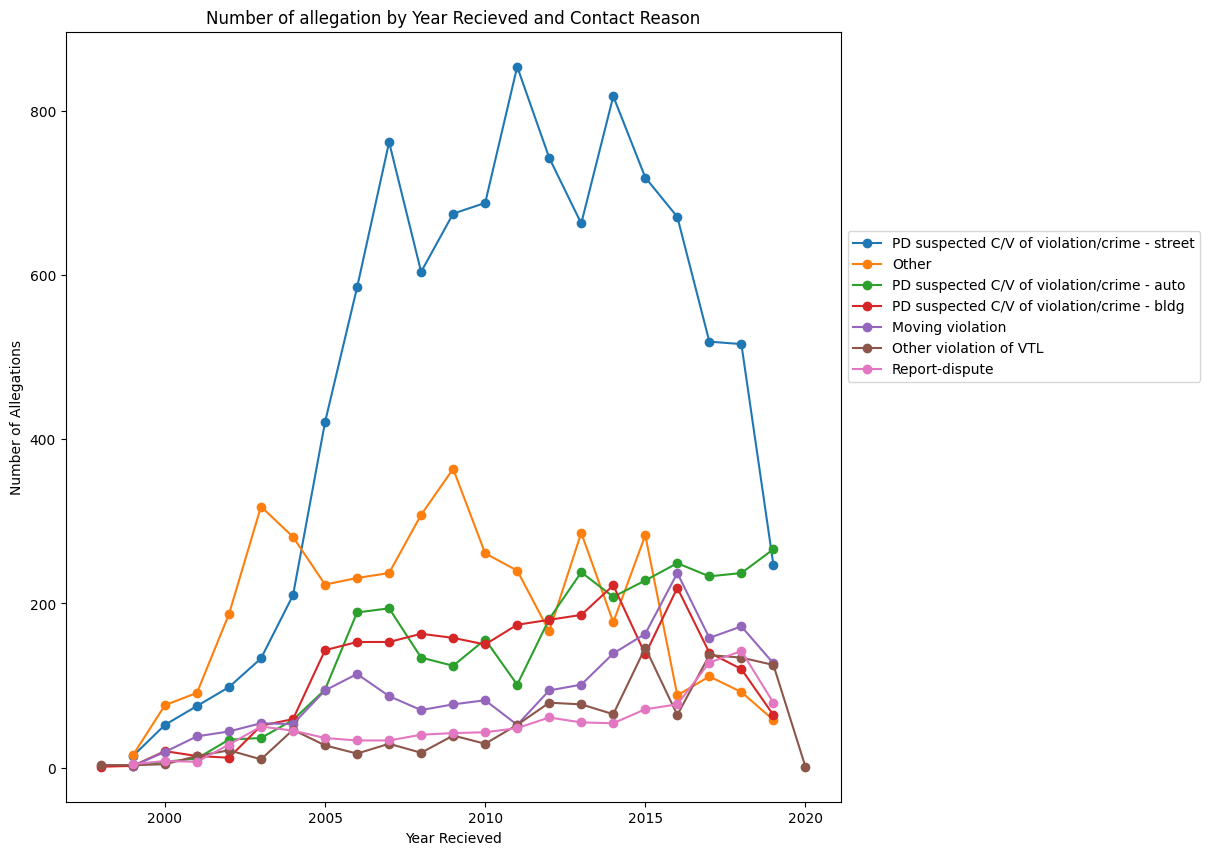

In [ ]:
figure, axis = plt.subplots()
plt.plot(graph.index, graph['PD suspected C/V of violation/crime - street'], label='PD suspected C/V of violation/crime - street',marker='o')
plt.plot(graph.index, graph['Other'], label='Other',marker='o')
plt.plot(graph.index, graph['PD suspected C/V of violation/crime - auto'], label='PD suspected C/V of violation/crime - auto',marker='o')
plt.plot(graph.index, graph['PD suspected C/V of violation/crime - bldg'], label='PD suspected C/V of violation/crime - bldg',marker='o')
plt.plot(graph.index, graph['Moving violation'], label='Moving violation',marker='o')
plt.plot(graph.index, graph['Other violation of VTL'], label='Other violation of VTL',marker='o')
plt.plot(graph.index, graph['Report-dispute'], label='Report-dispute',marker='o')

plt.xlabel('Year Recieved')
plt.ylabel('Number of Allegations')
plt.title('Number of allegation by Year Recieved and Contact Reason')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.75))

plt.show()


# **Graph 2**

The heatmap shows a clear trend of increasing complaints each year and the
months of January, February, november and december have the least complaints
throughout all years. It can also be observed that there weren’t many complaints from the
years 1985 -2004 and there has been a decent increase ever since then.

The trend of increasing complaints over the years, with notably fewer in the early months and last months of the year, might be influenced by factors such as seasonal changes in crime rates, police activity, or community-police engagement.


Contributed by: Mehak Miglani

In [ ]:
graph = df.pivot_table(index='year_received', columns='month_received', values='name', aggfunc='count')

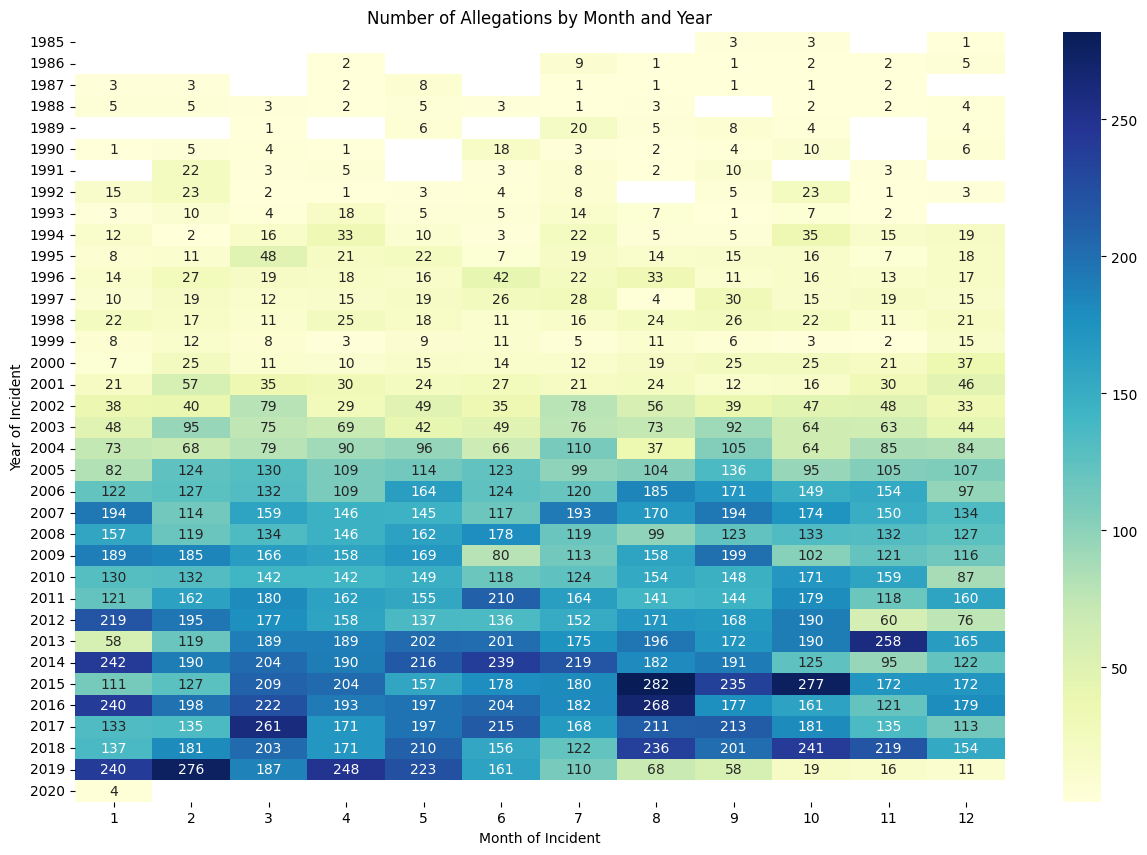

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(graph,  cmap='YlGnBu',annot=True, fmt='g')
plt.xlabel('Month of Incident')
plt.ylabel('Year of Incident')
plt.title('Number of Allegations by Month and Year')
plt.show()

# **Graph 3**

The graph depicts the neighborhoods and count of complaints registered on
them on the NYC map. The East New York neighborhood is shown to have the highest
complaints in all years and the Brooklyn area in general has the highest civilian
complaints.

The concentration of complaints in East New York and broader Brooklyn could point to local factors such as socio-economic conditions, policing practices, or community-police relations that necessitate focused policy interventions.


Contributed by: Aman Laiq Mohammed

<ipython-input-183-2cc40c5737ed>:7: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(plot_final)


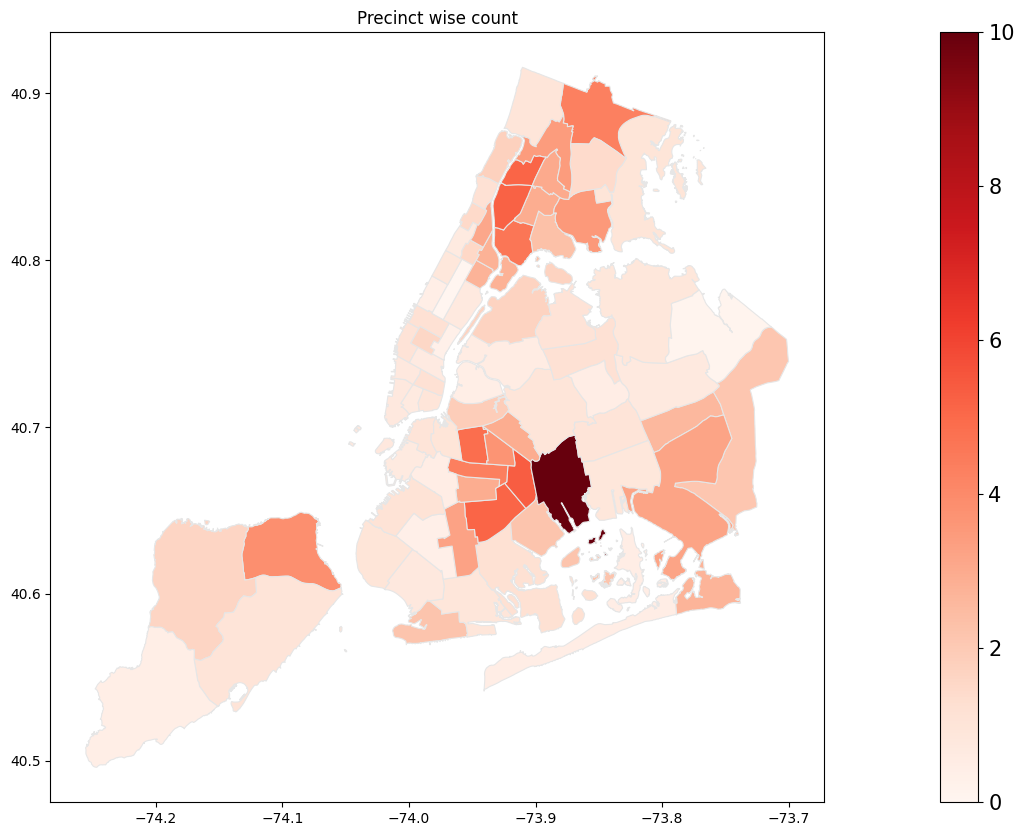

In [ ]:
fig, ax = plt.subplots(1, figsize=(30, 10))
color = 'Reds'
min_max = [0, 10]
def loc_plot():
    plot_final = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=min_max[0], vmax=min_max[1]))
    plot_final._A = []
    cbar = fig.colorbar(plot_final)
    merged_data.plot('frequency', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.9', figsize=(30,15))
    cbar.ax.tick_params(labelsize=15)
    plt.show()
ax.set_title('Precinct wise count')
loc_plot()

# **Graph 4**

The box plot depicts the age and ethnicity of the officer at the time of the
incident. It is observed that most of the officers that face charges are of age 27-37. The
mean ages of all ethnicities other than Black and American Indian are the same. Even
though Black officers are some of the youngest alleged officers, their mean age is higher
than the other ethnicities. The American Indian officers have the smallest age range and
smallest mean age for an officer alleged.

The observed age range and distribution among officers facing charges highlight the role of experience and age in incidents leading to allegations. The specific age demographics of Black and American Indian officers could reflect recruitment patterns or career progression within the force.



Contributed by: Animesh Nema

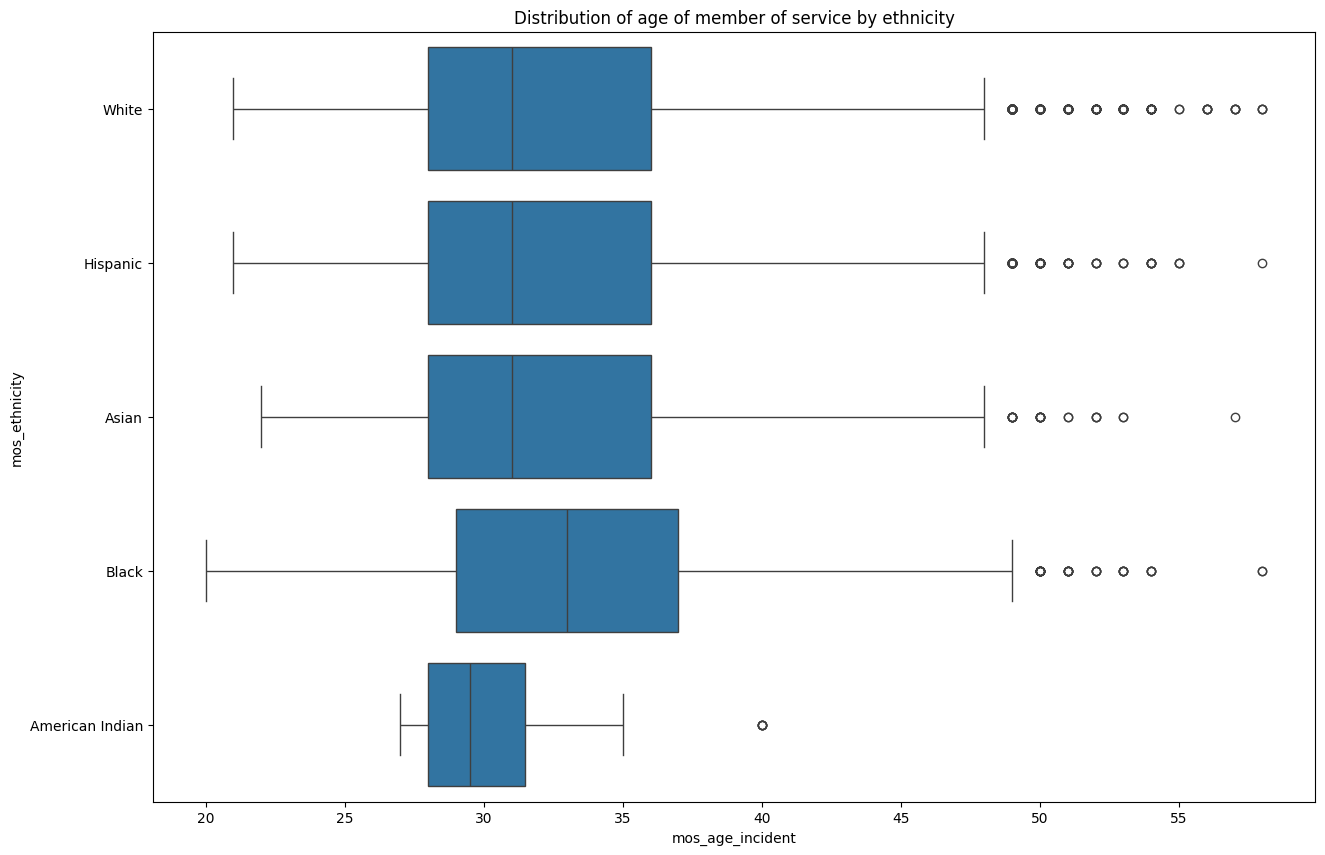

In [ ]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, x="mos_age_incident", y="mos_ethnicity")
plt.title('Distribution of age of member of service by ethnicity')
plt.show()

# **Graph 5**

The pie chart is used to visualize the percentage of complaints received by zip
codes. The zip code 11208 has the highest percentage of complaints and it falls under
75th precinct. All the other zip codes have almost similar complaints percentage.

The prevalence of complaints in the zip code 11208 may indicate unique local challenges or enforcement practices in the 76th precinct. The similarity across other zip codes suggests a baseline level of complaints that may be expected across different areas.


Contributed by: Chinmay Joshi

In [ ]:
pip install geopy

In [ ]:
merged_data_sorted

,precinct,shape_area,shape_leng,geometry,longitude,latitude,frequency,zipcode
46,75.0,1.804941e+08,106337.879200,"MULTIPOLYGON (((-73.85023 40.62332, -73.85023 ...",-73.87775660857048,40.665009662366174,2172,11208
45,73.0,5.175437e+07,33000.209960,"POLYGON ((-73.90405 40.67922, -73.90349 40.678...",-73.91094655789068,40.6681587790829,1163,11212
26,44.0,5.551179e+07,31464.134787,"POLYGON ((-73.90269 40.84458, -73.90271 40.844...",-73.9207952796168,40.83380611153094,1139,10452
28,46.0,3.833342e+07,29392.712842,"POLYGON ((-73.89138 40.86170, -73.89142 40.861...",-73.90957642771251,40.852746440383804,1120,10453
39,67.0,9.381497e+07,43255.869527,"POLYGON ((-73.90755 40.65119, -73.90849 40.650...",-73.93381756632431,40.64804204405852,1119,11203


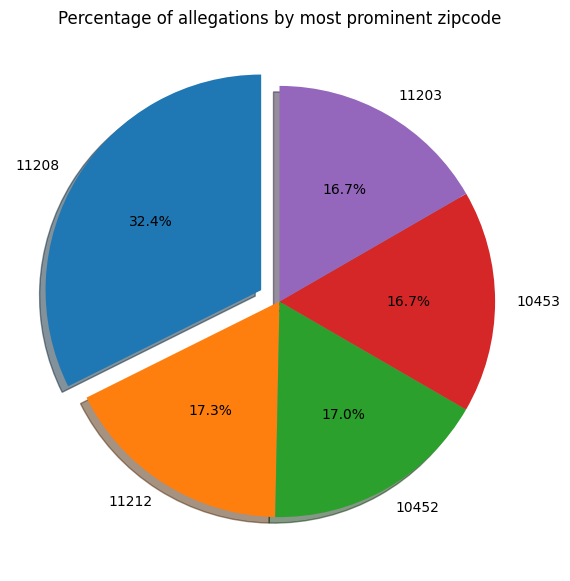

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.pie(merged_data_sorted['frequency'], labels=merged_data_sorted['zipcode'], autopct='%1.1f%%',shadow=True, startangle=90,explode = (0.1, 0, 0, 0,0))
ax.set_title("Percentage of allegations by most prominent zipcode")
plt.show()

# **Graph 6**

The bar graph between number of complaints with ranks (stacked using
ethnicity) shows that White Police officers have the highest number of complaints against
them followed by hispanic police officers and all the other rank categories show white
officers having higher complaints compared to other ethnic officers.

The higher number of complaints against White officers could indicate either a larger population of White officers, differences in the types of incidents they are involved in, or disparities in how complaints are reported and recorded across ethnic groups.


Contributed by: Jagriti Bhandari

In [ ]:
df_top_6_rank=df.rank_abbrev_incident.value_counts().index[0:6]
df_top_6_rank=df[df.rank_abbrev_incident.isin(df_top_6_rank)]

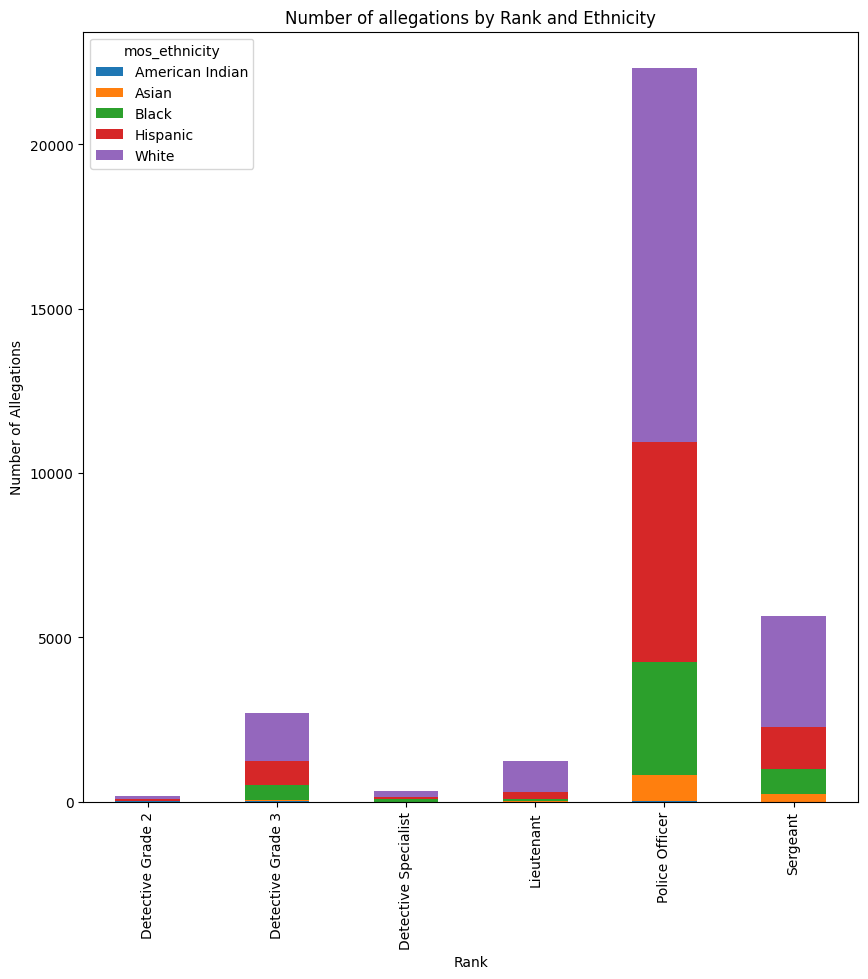

In [ ]:
graph = df_top_6_rank.groupby(['rank_abbrev_incident', 'mos_ethnicity']).size().reset_index(name='frequency')
graph = graph.pivot(index='rank_abbrev_incident', columns='mos_ethnicity', values='frequency')
graph.plot(kind='bar', stacked=True)
plt.title('Number of allegations by Rank and Ethnicity')
plt.xlabel('Rank')
plt.ylabel('Number of Allegations')
plt.rcParams['figure.figsize'] = [100, 10]
plt.show()

# **Graph 7**

The graph shows a comparison between male and female officers and the
number of complaints received. The trend clearly points to male officers having the
highest number of complaints irrespective of rank and the difference being abnormally
large.

The disproportionate number of complaints against male officers across all ranks suggests possible gender differences in policing style, behavior, or the nature of assignments, which could be vital for training and operational strategies.

Contributed by: Mehak Miglani

In [ ]:
top_6_rank=df.rank_abbrev_incident.value_counts().index[0:6]
df_top_6_rank=df[df['rank_abbrev_incident'].isin(top_6_rank)]

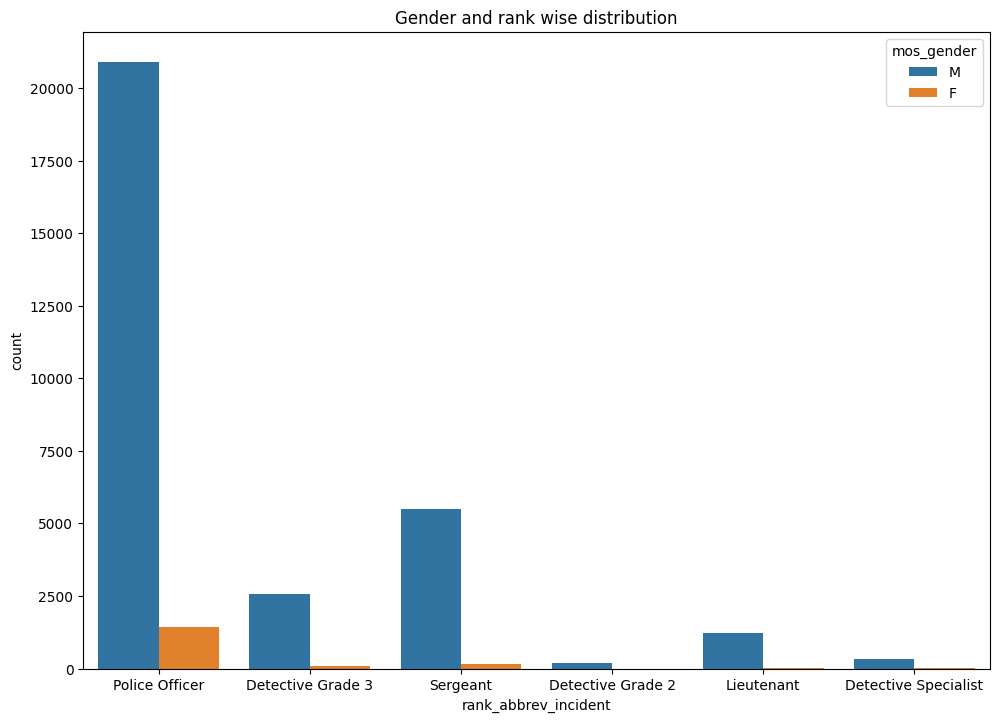

In [ ]:
fig, ax = pyplot.subplots(figsize=(11.7, 8.27))
sns.countplot(data=df_top_6_rank, x="rank_abbrev_incident",hue='mos_gender')
ax.set_title("Gender and rank wise distribution")
fig.show()

# **Graph 8**

The plot shows the Number of allegations vs the outcome description and
board disposition. ‘No arrests made or summons issued’ is the highest alleged outcome
with most of the cases being that the officer is unsubstantiated (not proven by evidence).
All other outcomes are less likely to happen and even in those cases, most of the officer
are unsubstantiated.

The high rate of allegations resulting in 'No arrest made or summons issued' and the high rate of unsubstantiated claims might suggest issues with the complaint vetting process, evidentiary standards, or public perception of police conduct.



Contributed by: Animesh Nema

In [ ]:
top_6_od=df.outcome_description.value_counts().index[0:6]
bd_df=df[['outcome_description','board_disposition']]
bd_df['board_disposition']=np.where(
    df['board_disposition']=="Unsubstantiated",
    "Unsubstantiated",
    np.where(
        df['board_disposition']=="Exonerated",
        "Exonerated",
        "Substantiated"
    )
)
types_bd=bd_df['board_disposition'].unique()
df_top_6_od_bd=bd_df[bd_df.outcome_description.isin(top_6_od)]

<ipython-input-192-7a9b5efa7260>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd_df['board_disposition']=np.where(


In [ ]:
bd_df.board_disposition.value_counts()

board_disposition
Unsubstantiated    15317
Exonerated          9521
Substantiated       8220
Name: count, dtype: int64

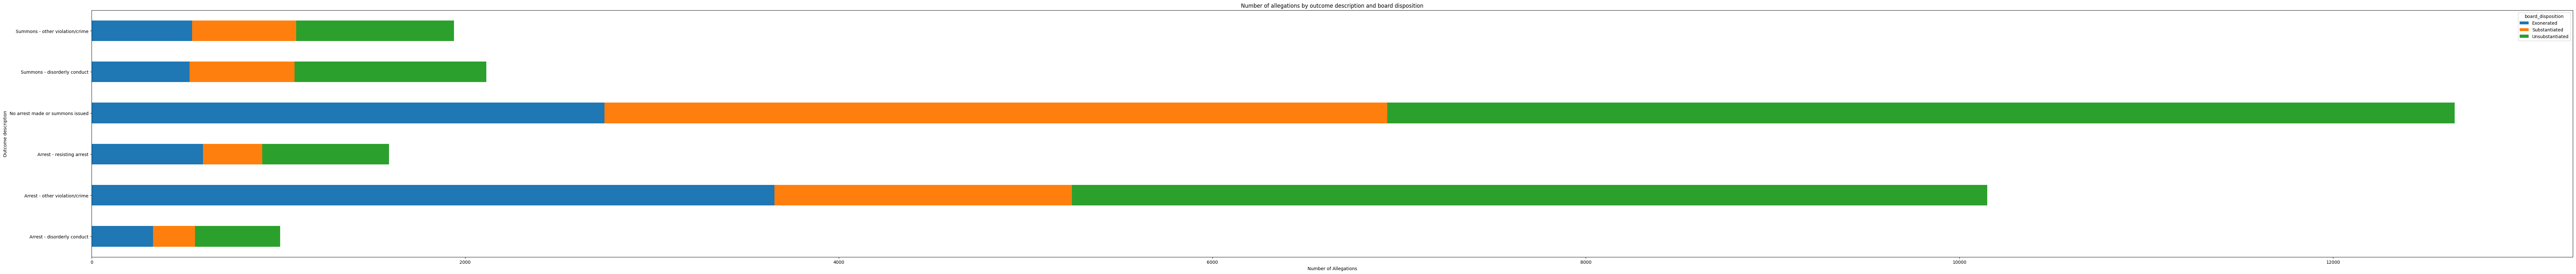

In [ ]:
graph = df_top_6_od_bd.groupby(['outcome_description', 'board_disposition']).size().reset_index(name='frequency')
graph = graph.pivot(index='outcome_description', columns='board_disposition', values='frequency')
graph.plot(kind='barh', stacked=True)
plt.title('Number of allegations by outcome description and board disposition')
plt.xlabel('Number of Allegations')
plt.ylabel('Outcome description')
plt.rcParams['figure.figsize'] = [100,10]
plt.show()

# **Graph 9**

The amount of time (days) taken to resolve a given complaint on the officer.
Abuse of authority is observed to be the most frequent and most time taking complaint to
be resolved with other categories taking just 1/3rd of this time.

The longer resolution time for abuse of authority complaints might reflect their complexity and seriousness, pointing to potential inefficiencies in the review process that could benefit from streamlined procedures or additional resources.


Contributed by: Aman Laiq Mohammed

In [ ]:
df['bins_day'].value_counts().index[0:4]

Index([6.0, 5.0, 7.0, 10.0], dtype='float64', name='bins_day')

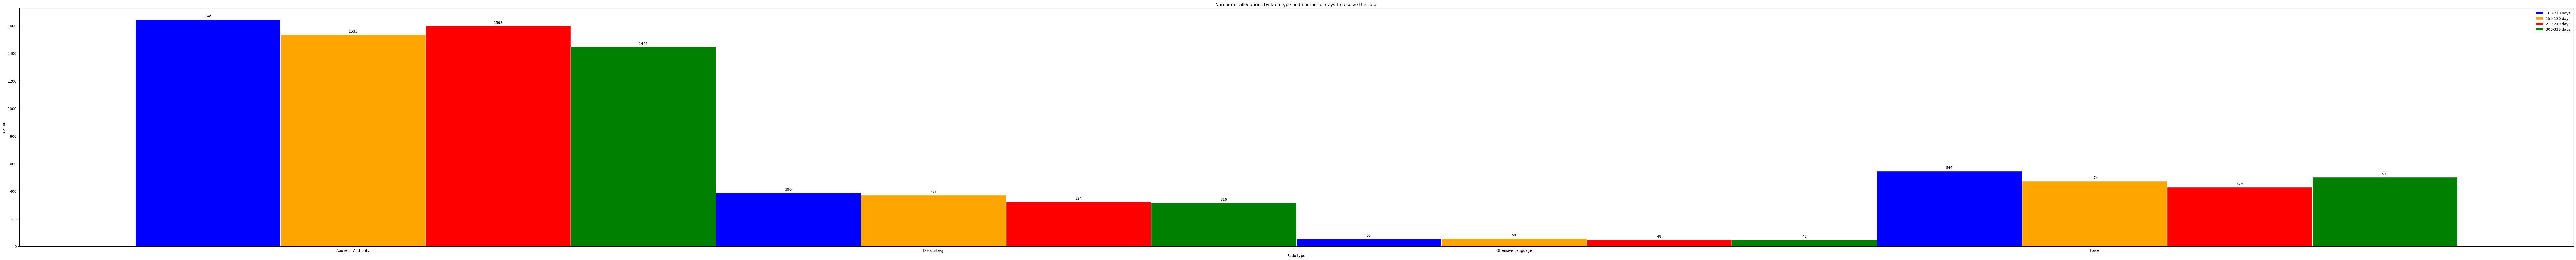

In [ ]:
def helper(binNum,fado_type):
    return df[(df["bins_day"]==binNum) & (df["fado_type"]==fado_type)].shape[0]

labels = ['Abuse of Authority','Discourtesy','Offensive Language','Force']
bin1 = [helper(6,labels[0]), helper(6,labels[1]), helper(6,labels[2]), helper(6,labels[3])]
bin2 = [helper(5,labels[0]), helper(5,labels[1]), helper(5,labels[2]), helper(5,labels[3])]
bin3 = [helper(7,labels[0]), helper(7,labels[1]), helper(7,labels[2]), helper(7,labels[3])]
bin4 = [helper(10,labels[0]), helper(10,labels[1]), helper(10,labels[2]), helper(10,labels[3])]

width = 0.25
fig, ax = plt.subplots(constrained_layout=True)

r1 = np.arange(len(bin1))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]

o=width*0
a1=plt.bar(r1+o, bin1, color='blue', width=width, edgecolor='white', label='180-210 days')
ax.bar_label(a1, padding=4)
o=width*1
a2=plt.bar(o+r1, bin2, color='orange', width=width, edgecolor='white', label='150-180 days')
ax.bar_label(a2, padding=4)
o=width*2
a3=plt.bar(o+r1, bin3, color='red', width=width, edgecolor='white', label='210-240 days')
ax.bar_label(a3, padding=4)
o=width*3
a4=plt.bar(o+r1, bin4, color='green', width=width, edgecolor='white', label='300-330 days')
ax.bar_label(a4, padding=4)

plt.xlabel('Fado type')
plt.ylabel('Count')
plt.xticks(r1 + width, labels)
plt.title('Number of allegations by fado type and number of days to resolve the case')
plt.rcParams['figure.figsize'] = [200,20]

plt.legend()
plt.show()

# **Graph 10**

The scatterplot shows the age, gender of the complainant and number of days
taken to resolve the issue. It can be seen that female complaints have steadily increased
with age and male complaints taking more days to resolve compared to other genders.

The pattern of female complaints increasing with age and male complaints taking longer to resolve might indicate underlying differences in the experiences and perceptions of police conduct between genders, as well as potential biases in the resolution process.

Contributed by: Chinmay Joshi

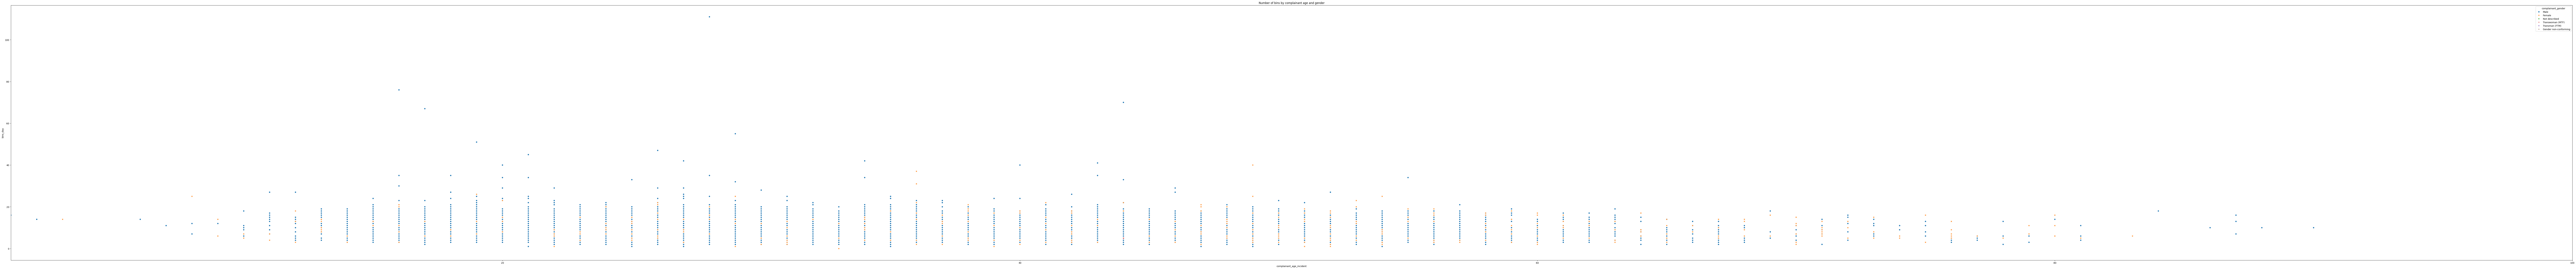

In [ ]:
ax=sns.scatterplot(data=df, x="complainant_age_incident", y="bins_day",hue="complainant_gender",style="complainant_gender",color=".2")
ax.set(xlim=(1,100))
plt.rcParams['figure.figsize'] = [10,10]
plt.title('Number of bins by complainant age and gender')
plt.show()

# Graph 11

In [ ]:
print(df['outcome_description'].unique())

['No arrest made or summons issued' 'Summons - other violation/crime'
 'Arrest - other violation/crime' 'Parking summons issued'
 'Other VTL violation summons issued' 'Summons - disorderly conduct'
 'Moving violation summons issued' 'Arrest - resisting arrest'
 'Arrest - disorderly conduct' 'Arrest - OGA'
 'Arrest - assault (against a PO)' 'Arrest on Other Charge'
 'Disorderly-Conduct/Arr/Summons' 'Traffic Summons Claimed or Issued'
 'Resisting Arrest/Arrested' 'Assault/Arrested'
 'Other Summons Claimed or Issued' 'Harrassment/Arrested/Summons'
 'Arrest - harrassment (against a PO)' 'Juvenile Report'
 'Summons - harrassment (against a PO)' 'Obstruct-Govt-Admin/Arrested'
 'Summons - OGA']


In [ ]:
severity_mapping = {
    'No arrest made or summons issued': 1,
    'Summons - other violation/crime': 2,
    'Arrest - other violation/crime': 3,
    'Parking summons issued': 1,
    'Other VTL violation summons issued': 1,
    'Summons - disorderly conduct': 2,
    'Moving violation summons issued': 1,
    'Arrest - resisting arrest': 3,
    'Arrest - disorderly conduct': 3,
    'Arrest - OGA': 3,
    'Arrest - assault (against a PO)': 4,
    'Arrest on Other Charge': 3,
    'Disorderly-Conduct/Arr/Summons': 3,
    'Traffic Summons Claimed or Issued': 1,
    'Resisting Arrest/Arrested': 3,
    'Assault/Arrested': 4,
    'Other Summons Claimed or Issued': 2,
    'Harrassment/Arrested/Summons': 3,
    'Arrest - harrassment (against a PO)': 4,
    'Juvenile Report': 1,
    'Summons - harrassment (against a PO)': 3,
    'Obstruct-Govt-Admin/Arrested': 3,
    'Summons - OGA': 3
}

df['severity_level'] = df['outcome_description'].map(severity_mapping)

print(df[['outcome_description', 'severity_level']])


                    outcome_description  severity_level
0      No arrest made or summons issued               1
1      No arrest made or summons issued               1
2       Summons - other violation/crime               2
3       Summons - other violation/crime               2
4        Arrest - other violation/crime               3
...                                 ...             ...
33305   Summons - other violation/crime               2
33306    Arrest - other violation/crime               3
33307    Arrest - other violation/crime               3
33308    Arrest - other violation/crime               3
33309    Arrest - other violation/crime               3

[33058 rows x 2 columns]


In [ ]:
if 'case_count' not in df.columns:
    df['case_count'] = df.groupby(['bins_day', 'severity_level'])['outcome_description'].transform('count')

summary_df = df.groupby(['bins_day', 'severity_level'])['case_count'].sum().unstack(fill_value=0)

print(summary_df.head())

severity_level        1      2       3     4
bins_day                                    
0.0             1359556   1225   68121  1156
1.0                 676      4      36     0
2.0               11025    441    3481     4
3.0              207025   8464   66564     4
4.0              891136  75076  398161  2116


In [ ]:
print(summary_df.head())


severity_level        1      2       3     4
bins_day                                    
0.0             1359556   1225   68121  1156
1.0                 676      4      36     0
2.0               11025    441    3481     4
3.0              207025   8464   66564     4
4.0              891136  75076  398161  2116


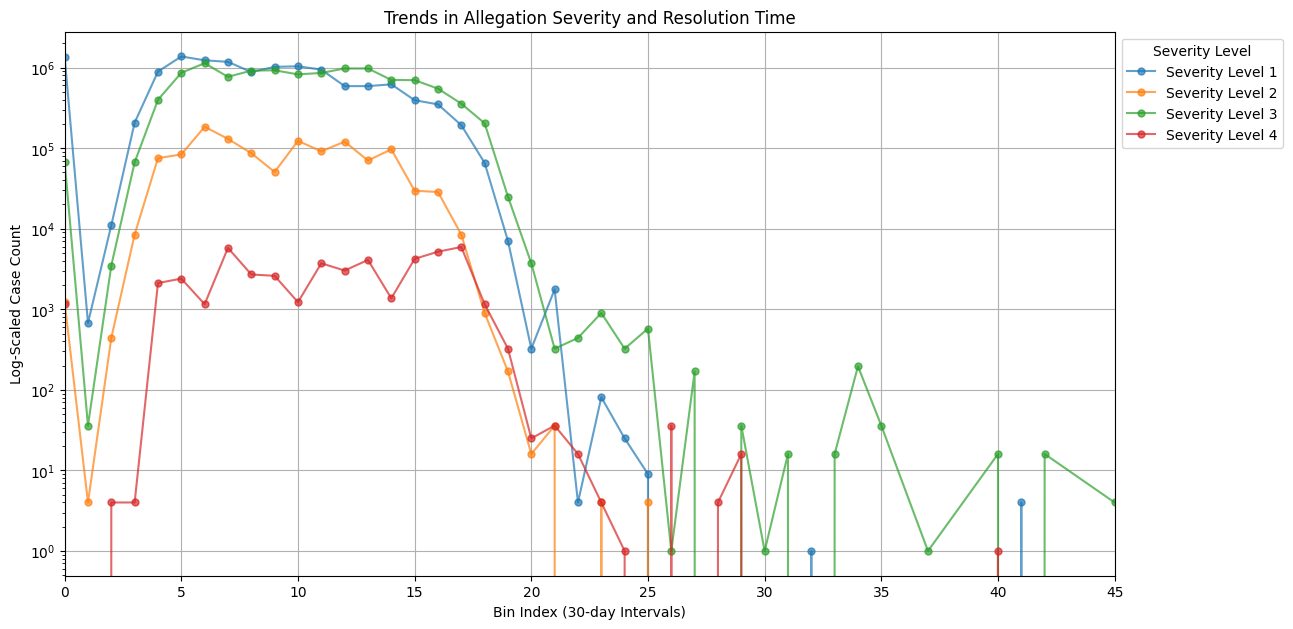

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.figure(figsize=(15, 8))
colors = list(mcolors.TABLEAU_COLORS)

for index, (severity, data) in enumerate(summary_df.items()):
    plt.plot(summary_df.index, data, marker='o', linestyle='-', label=f'Severity Level {severity}',
             color=colors[index % len(colors)], markersize=5, alpha=0.7)

plt.xticks(range(0, len(summary_df.index), 5))

plt.yscale('log')

plt.xlim(left=0, right=45)

plt.legend(title='Severity Level', bbox_to_anchor=(1, 1), loc='upper left')

plt.grid(True)
plt.title('Trends in Allegation Severity and Resolution Time')
plt.xlabel('Bin Index (30-day Intervals)')
plt.ylabel('Log-Scaled Case Count')

plt.subplots_adjust(left=0.2, bottom=0.2)

plt.show()


# Graph 12:

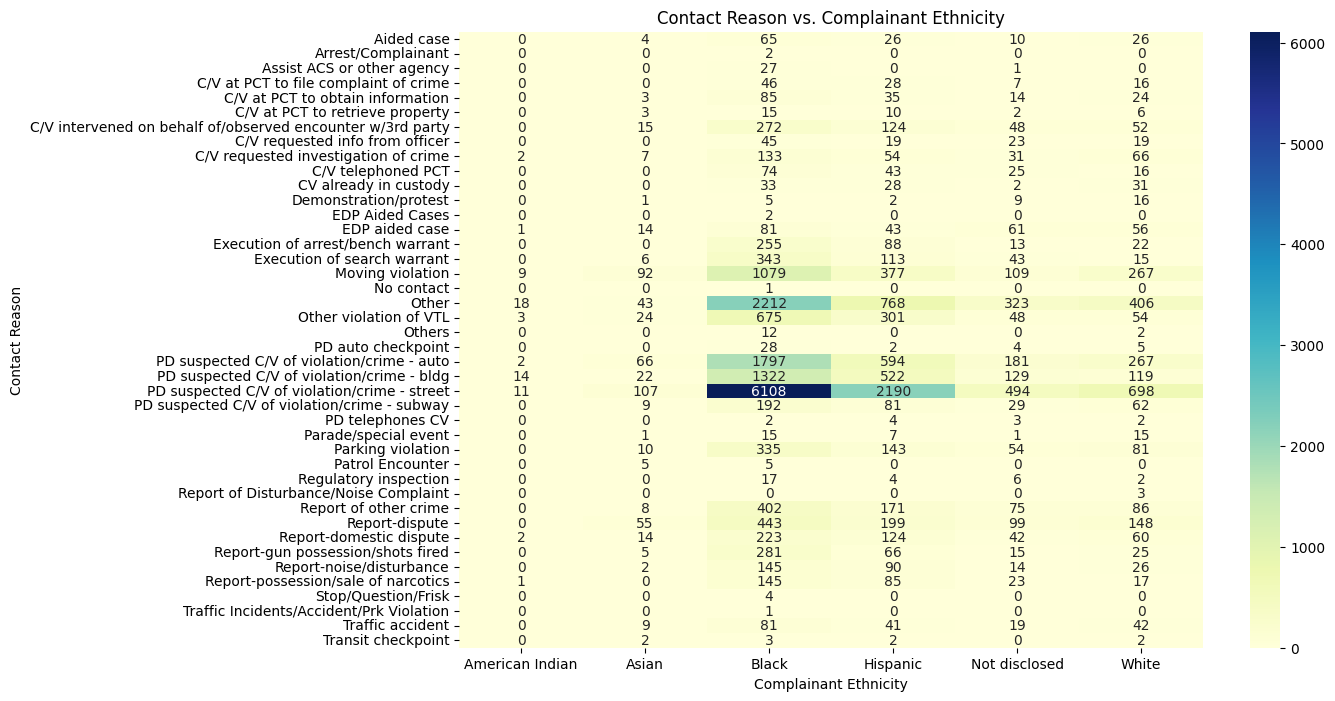

In [ ]:
ethnicity_contact_crosstab = pd.crosstab(df['contact_reason'], df['complainant_ethnicity'])

plt.figure(figsize=(12, 8))
sns.heatmap(ethnicity_contact_crosstab, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Contact Reason vs. Complainant Ethnicity')
plt.xlabel('Complainant Ethnicity')
plt.ylabel('Contact Reason')
plt.show()


# **Graph** 13

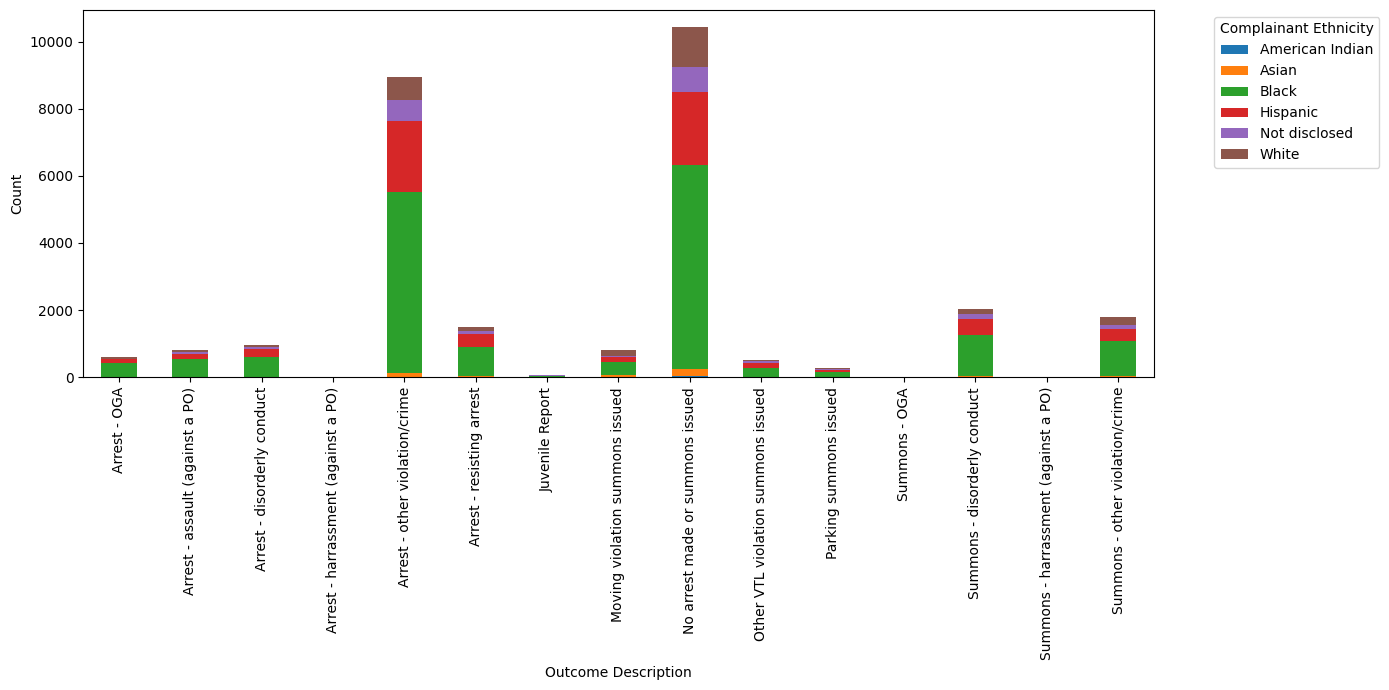

In [ ]:
ethnicity_outcome_crosstab = pd.crosstab(df['outcome_description'], df['complainant_ethnicity'])
ethnicity_outcome_crosstab.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.xlabel('Outcome Description')
plt.ylabel('Count')
plt.legend(title='Complainant Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90, ha='center')

plt.tight_layout()
plt.show()


Graph 14:

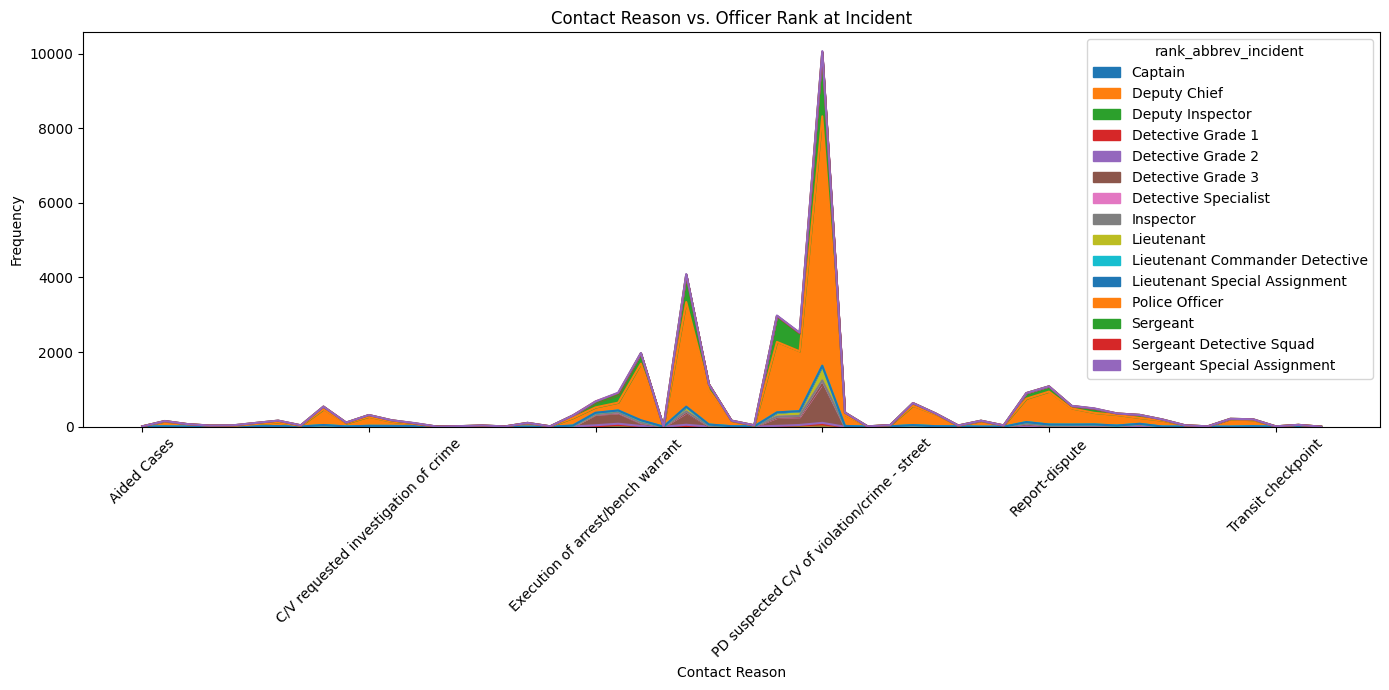

In [ ]:
rank_contact_crosstab = pd.crosstab(df['contact_reason'], df['rank_abbrev_incident'])
rank_contact_crosstab.plot(kind='area', stacked=True, figsize=(14, 7))
plt.title('Contact Reason vs. Officer Rank at Incident')
plt.xlabel('Contact Reason')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




Graph 15:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

reason = most_common_contactreason[0]
filtered_data = df[df['contact_reason'] == reason]

filtered_data = filtered_data.groupby('year_received').size().reset_index(name='count')

filtered_data['year_received'] = pd.to_numeric(filtered_data['year_received'], errors='coerce')


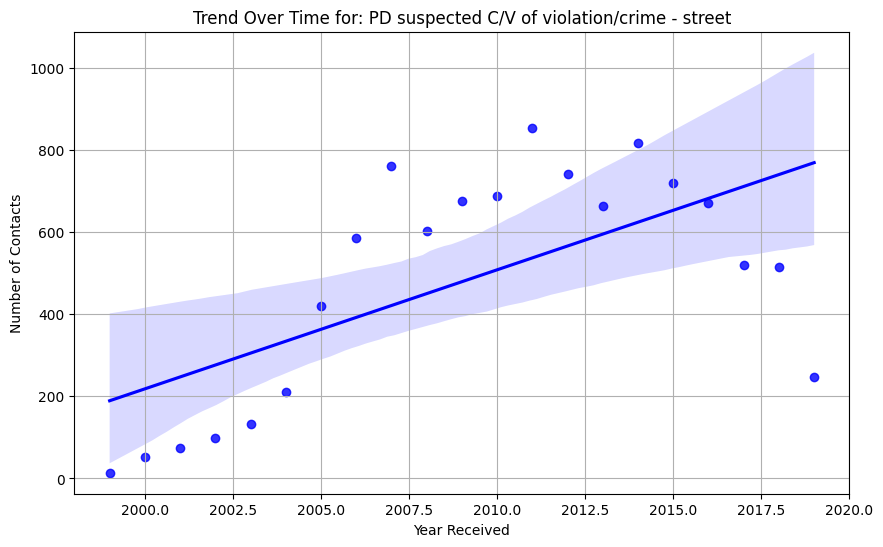

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='year_received', y='count', data=filtered_data, scatter=True, fit_reg=True, marker='o', color='blue')
plt.title(f'Trend Over Time for: {reason}')
plt.xlabel('Year Received')
plt.ylabel('Number of Contacts')
plt.grid(True)
plt.show()


# Graph 16:

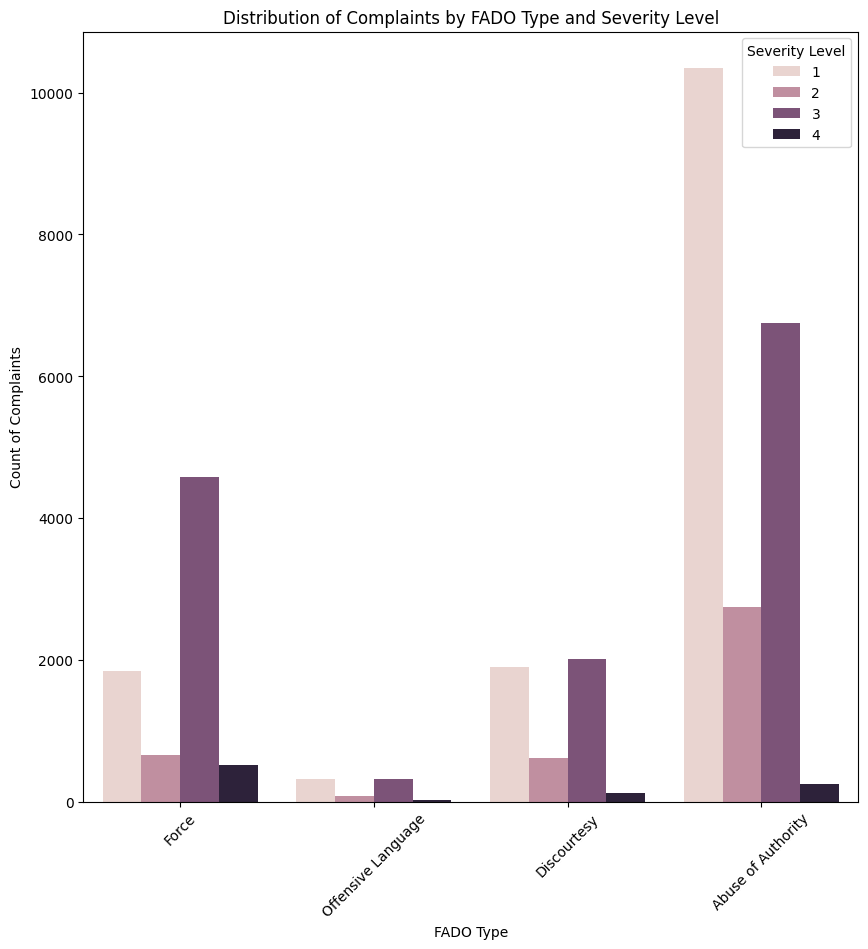

In [ ]:
sns.countplot(x='fado_type', hue='severity_level', data=df)
plt.title('Distribution of Complaints by FADO Type and Severity Level')
plt.xlabel('FADO Type')
plt.ylabel('Count of Complaints')
plt.xticks(rotation=45)
plt.legend(title='Severity Level')
plt.show()


# Graph 17

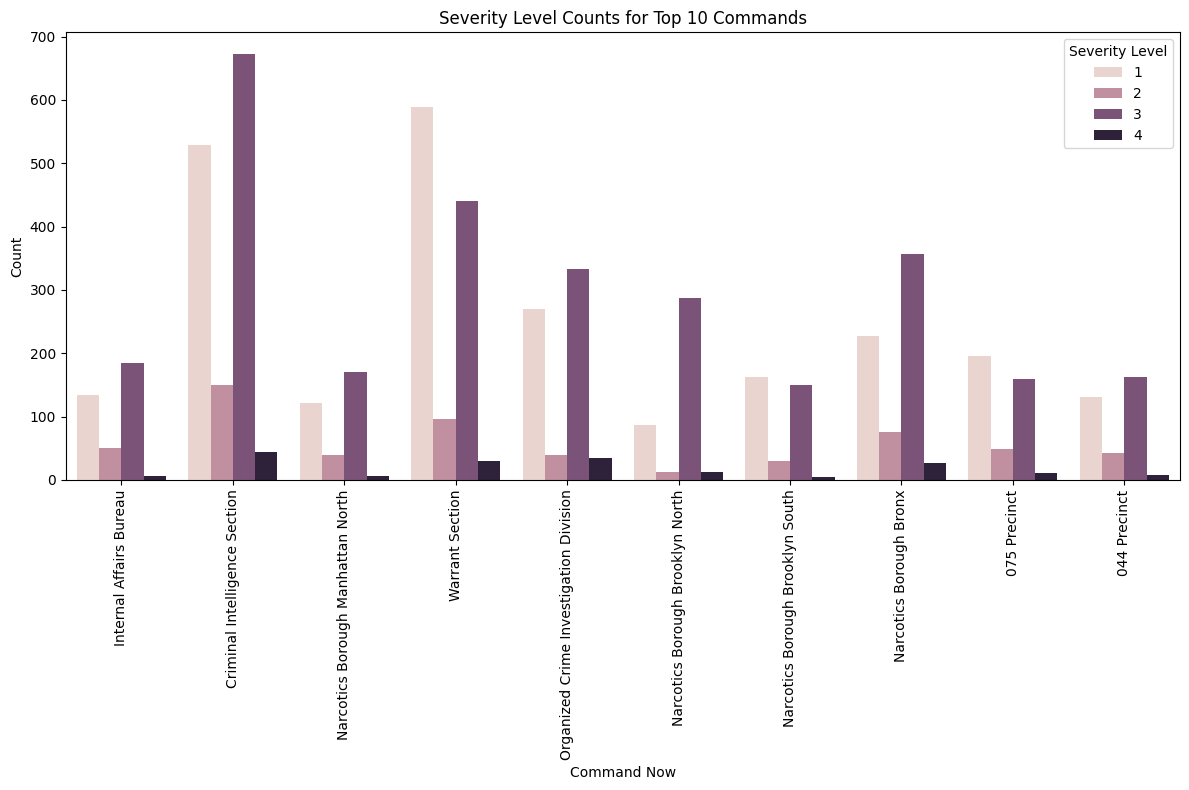

In [ ]:
top_commands = df['command_now'].value_counts().nlargest(10).index
top_commands_df = df[df['command_now'].isin(top_commands)]
plt.figure(figsize=(12, 8))
sns.countplot(x='command_now', hue='severity_level', data=top_commands_df)
plt.title('Severity Level Counts for Top 10 Commands')
plt.xlabel('Command Now')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Severity Level')
plt.tight_layout()
plt.show()


# **Removing outliers after EDA**

In [ ]:
#From boxplot we got the outliers for the columnmos_age_incident

df.drop(df[df.mos_age_incident >=48].index, inplace=True)

In [ ]:
#From boxplot we got the outliers for the bins_day(externally generated column)

df.drop(df[df.bins_day >=20].index, inplace=True)

In [ ]:
df=df.dropna()

In [ ]:
df_dropped=df.drop(['complaint_id','outcome_description','longitude',
'latitude','geometry','shape_area','name','shape_leng','date_received','date_closed','bins_day'],axis=1)

In [ ]:
df.columns

Index(['unique_mos_id', 'command_now', 'complaint_id', 'month_received',
       'year_received', 'month_closed', 'year_closed', 'command_at_incident',
       'rank_abbrev_incident', 'rank_abbrev_now', 'mos_ethnicity',
       'mos_gender', 'mos_age_incident', 'complainant_ethnicity',
       'complainant_gender', 'complainant_age_incident', 'fado_type',
       'allegation', 'precinct', 'contact_reason', 'outcome_description',
       'board_disposition', 'shape_area', 'shape_leng', 'geometry',
       'longitude', 'latitude', 'date_received', 'date_closed',
       'days_taken_to_resolve', 'bins_day', 'name', 'severity_level',
       'case_count'],
      dtype='object')

In [ ]:
df_dropped.columns

Index(['unique_mos_id', 'command_now', 'month_received', 'year_received',
       'month_closed', 'year_closed', 'command_at_incident',
       'rank_abbrev_incident', 'rank_abbrev_now', 'mos_ethnicity',
       'mos_gender', 'mos_age_incident', 'complainant_ethnicity',
       'complainant_gender', 'complainant_age_incident', 'fado_type',
       'allegation', 'precinct', 'contact_reason', 'board_disposition',
       'days_taken_to_resolve', 'severity_level', 'case_count'],
      dtype='object')

In [ ]:
df.unique_mos_id.value_counts()

unique_mos_id
25861    70
18731    67
25814    57
20982    52
25785    45
         ..
27399     1
35960     1
10212     1
24642     1
36031     1
Name: count, Length: 3681, dtype: int64

In [ ]:
df.name.value_counts()

name
Mathew Reich          70
Daniel Sbarra         67
William Taylor        57
Mike Civil            52
Matthew Lewis         45
                      ..
Minhaj Khalique        1
Kevin Beslity          1
Angelica Casilimas     1
Jimmy Castillo         1
Brian Mcgee            1
Name: count, Length: 3646, dtype: int64

## **One Hot Encoding**

In [ ]:
df_encoding=pd.get_dummies(df_dropped)

In [ ]:
df_dropped.dtypes

unique_mos_id                 int64
command_now                  object
month_received                int64
year_received                 int64
month_closed                  int64
year_closed                   int64
command_at_incident          object
rank_abbrev_incident         object
rank_abbrev_now              object
mos_ethnicity                object
mos_gender                   object
mos_age_incident              int64
complainant_ethnicity        object
complainant_gender           object
complainant_age_incident    float64
fado_type                    object
allegation                   object
precinct                    float64
contact_reason               object
board_disposition            object
days_taken_to_resolve         int64
severity_level                int64
case_count                    int64
dtype: object

In [ ]:
df_encoding

,unique_mos_id,month_received,year_received,month_closed,year_closed,mos_age_incident,complainant_age_incident,precinct,days_taken_to_resolve,severity_level,...,board_disposition_Exonerated,board_disposition_Substantiated (Charges),board_disposition_Substantiated (Command Discipline A),board_disposition_Substantiated (Command Discipline B),board_disposition_Substantiated (Command Discipline),board_disposition_Substantiated (Command Lvl Instructions),board_disposition_Substantiated (Formalized Training),board_disposition_Substantiated (Instructions),board_disposition_Substantiated (No Recommendations),board_disposition_Unsubstantiated
0,10134,10,2011,8,2012,24,32.0,1.0,305,1,...,False,False,False,False,False,False,False,False,False,True
1,10134,10,2011,8,2012,24,32.0,1.0,305,1,...,True,False,False,False,False,False,False,False,False,False
2,10134,10,2012,3,2013,25,52.0,1.0,151,2,...,False,False,False,False,False,False,False,False,False,True
3,10134,10,2012,3,2013,25,52.0,1.0,151,2,...,False,False,False,False,False,False,False,False,False,True
4,10134,4,2015,10,2015,28,44.0,1.0,183,3,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33304,32623,5,2017,9,2017,31,42.0,123.0,123,1,...,False,False,False,False,False,False,False,False,False,True
33305,32623,8,2015,12,2015,30,17.0,123.0,122,2,...,True,False,False,False,False,False,False,False,False,False
33306,32623,4,2016,9,2016,30,18.0,123.0,153,3,...,False,False,False,False,False,False,False,False,False,True
33308,8305,8,2006,7,2007,24,16.0,123.0,334,3,...,True,False,False,False,False,False,False,False,False,False


# **Min-Max scaling**

In [ ]:
numerical_cols=['unique_mos_id',
       'month_received', 'year_received', 'month_closed', 'year_closed',
       'mos_age_incident',
       'complainant_age_incident', 'precinct', 'days_taken_to_resolve'
       ]

for cols in numerical_cols:
    min_val=df_encoding[cols].min()
    max_val=df_encoding[cols].max()
    scaling_factor=max_val-min_val
    df_encoding[cols]=(df_encoding[cols]-min_val)/scaling_factor

df_encoding_scaled=df_encoding.round(3)

In [ ]:
df_encoding_scaled

,unique_mos_id,month_received,year_received,month_closed,year_closed,mos_age_incident,complainant_age_incident,precinct,days_taken_to_resolve,severity_level,...,board_disposition_Exonerated,board_disposition_Substantiated (Charges),board_disposition_Substantiated (Command Discipline A),board_disposition_Substantiated (Command Discipline B),board_disposition_Substantiated (Command Discipline),board_disposition_Substantiated (Command Lvl Instructions),board_disposition_Substantiated (Formalized Training),board_disposition_Substantiated (Instructions),board_disposition_Substantiated (No Recommendations),board_disposition_Unsubstantiated
0,0.279,0.818,0.591,0.636,0.60,0.115,0.984,0.0,0.501,1,...,False,False,False,False,False,False,False,False,False,True
1,0.279,0.818,0.591,0.636,0.60,0.115,0.984,0.0,0.501,1,...,True,False,False,False,False,False,False,False,False,False
2,0.279,0.818,0.636,0.182,0.65,0.154,0.989,0.0,0.222,2,...,False,False,False,False,False,False,False,False,False,True
3,0.279,0.818,0.636,0.182,0.65,0.154,0.989,0.0,0.222,2,...,False,False,False,False,False,False,False,False,False,True
4,0.279,0.273,0.773,0.818,0.75,0.269,0.987,0.0,0.280,3,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33304,0.898,0.364,0.864,0.727,0.85,0.385,0.987,1.0,0.172,1,...,False,False,False,False,False,False,False,False,False,True
33305,0.898,0.636,0.773,1.000,0.75,0.346,0.981,1.0,0.170,2,...,True,False,False,False,False,False,False,False,False,False
33306,0.898,0.273,0.818,0.727,0.80,0.346,0.981,1.0,0.226,3,...,False,False,False,False,False,False,False,False,False,True
33308,0.228,0.636,0.364,0.545,0.35,0.115,0.981,1.0,0.553,3,...,True,False,False,False,False,False,False,False,False,False


In [ ]:
df_encoding_scaled.head()

,unique_mos_id,month_received,year_received,month_closed,year_closed,mos_age_incident,complainant_age_incident,precinct,days_taken_to_resolve,severity_level,...,board_disposition_Exonerated,board_disposition_Substantiated (Charges),board_disposition_Substantiated (Command Discipline A),board_disposition_Substantiated (Command Discipline B),board_disposition_Substantiated (Command Discipline),board_disposition_Substantiated (Command Lvl Instructions),board_disposition_Substantiated (Formalized Training),board_disposition_Substantiated (Instructions),board_disposition_Substantiated (No Recommendations),board_disposition_Unsubstantiated
0,0.279,0.818,0.591,0.636,0.60,0.115,0.984,0.0,0.501,1,...,False,False,False,False,False,False,False,False,False,True
1,0.279,0.818,0.591,0.636,0.60,0.115,0.984,0.0,0.501,1,...,True,False,False,False,False,False,False,False,False,False
2,0.279,0.818,0.636,0.182,0.65,0.154,0.989,0.0,0.222,2,...,False,False,False,False,False,False,False,False,False,True
3,0.279,0.818,0.636,0.182,0.65,0.154,0.989,0.0,0.222,2,...,False,False,False,False,False,False,False,False,False,True
4,0.279,0.273,0.773,0.818,0.75,0.269,0.987,0.0,0.280,3,...,False,True,False,False,False,False,False,False,False,False


# **Target Variable: Board Disposition - KNN, Random Forest and Gradiant Boost**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler as RUS
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import plot_tree

In [ ]:
from sklearn.preprocessing import LabelEncoder
for column in ['year_received','command_now','month_received','fado_type', 'allegation', 'precinct', 'complainant_ethnicity', 'complainant_gender','contact_reason','command_at_incident',
       'rank_abbrev_incident', 'rank_abbrev_now']:
    df[column] = LabelEncoder().fit_transform(df[column].astype(str))

X = df[['mos_age_incident', 'precinct', 'fado_type', 'allegation','complainant_ethnicity', 'complainant_gender','contact_reason','month_received','command_now','command_at_incident',
       'rank_abbrev_incident', 'rank_abbrev_now']]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
df_dropped.columns

Index(['unique_mos_id', 'command_now', 'month_received', 'year_received',
       'month_closed', 'year_closed', 'command_at_incident',
       'rank_abbrev_incident', 'rank_abbrev_now', 'mos_ethnicity',
       'mos_gender', 'mos_age_incident', 'complainant_ethnicity',
       'complainant_gender', 'complainant_age_incident', 'fado_type',
       'allegation', 'precinct', 'contact_reason', 'board_disposition',
       'days_taken_to_resolve', 'severity_level', 'case_count'],
      dtype='object')

In [ ]:
df_encoding_scaled.columns

Index(['unique_mos_id', 'month_received', 'year_received', 'month_closed',
       'year_closed', 'mos_age_incident', 'complainant_age_incident',
       'precinct', 'days_taken_to_resolve', 'severity_level',
       ...
       'board_disposition_Exonerated',
       'board_disposition_Substantiated (Charges)',
       'board_disposition_Substantiated (Command Discipline A)',
       'board_disposition_Substantiated (Command Discipline B)',
       'board_disposition_Substantiated (Command Discipline)',
       'board_disposition_Substantiated (Command Lvl Instructions)',
       'board_disposition_Substantiated (Formalized Training)',
       'board_disposition_Substantiated (Instructions)',
       'board_disposition_Substantiated (No Recommendations)',
       'board_disposition_Unsubstantiated'],
      dtype='object', length=835)

In [ ]:
df_target=pd.DataFrame(np.where(
    df_dropped['board_disposition']=="Unsubstantiated",
    "Unsubstantiated",
    np.where(
        df_dropped['board_disposition']=="Exonerated",
        "Exonerated",
        "Substantiated"
    )
), columns=['board_disposition'])

In [ ]:
#X=df_encoding_scaled.loc[:, ~df_encoding_scaled.columns.str.startswith('board_disposition')]
Y=df_target['board_disposition']

In [ ]:
df_target['board_disposition'].value_counts()

board_disposition
Unsubstantiated    12719
Exonerated          7297
Substantiated       6556
Name: count, dtype: int64

In [ ]:
X= X.dropna()
Y= Y.dropna()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [ ]:
X_test

,mos_age_incident,precinct,fado_type,allegation,complainant_ethnicity,complainant_gender,contact_reason,month_received,command_now,command_at_incident,rank_abbrev_incident,rank_abbrev_now
31692,32,17,2,36,2,2,16,6,344,109,11,14
8306,31,41,0,41,2,2,18,0,220,217,11,9
21263,30,65,1,76,2,2,24,1,288,148,11,15
1428,37,23,0,71,2,2,22,8,297,180,8,12
6673,29,38,0,68,3,2,24,4,38,31,11,14
...,...,...,...,...,...,...,...,...,...,...,...,...
17297,25,59,0,60,2,2,16,1,76,61,11,14
27020,37,76,1,76,3,2,35,1,264,86,12,11
27701,30,3,0,42,2,2,24,0,311,89,12,1
32228,35,18,0,57,5,2,18,5,173,111,11,14


In [ ]:
pca = PCA(n_components = 12)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train_pca, y_train)

y_pred_knn = knn.predict(X_test_pca)

In [ ]:
y_pred = y_pred_knn
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}")

Accuracy: 0.46415804327375354, Precision: 0.4658987923305739, Recall: 0.46415804327375354, F1-score: 0.46493956229876


In [ ]:
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.46415804327375354
                 precision    recall  f1-score   support

     Exonerated       0.39      0.41      0.40      1436
  Substantiated       0.36      0.35      0.36      1323
Unsubstantiated       0.56      0.55      0.56      2556

       accuracy                           0.46      5315
      macro avg       0.44      0.44      0.44      5315
   weighted avg       0.47      0.46      0.46      5315

[[ 589  294  553]
 [ 316  469  538]
 [ 597  550 1409]]


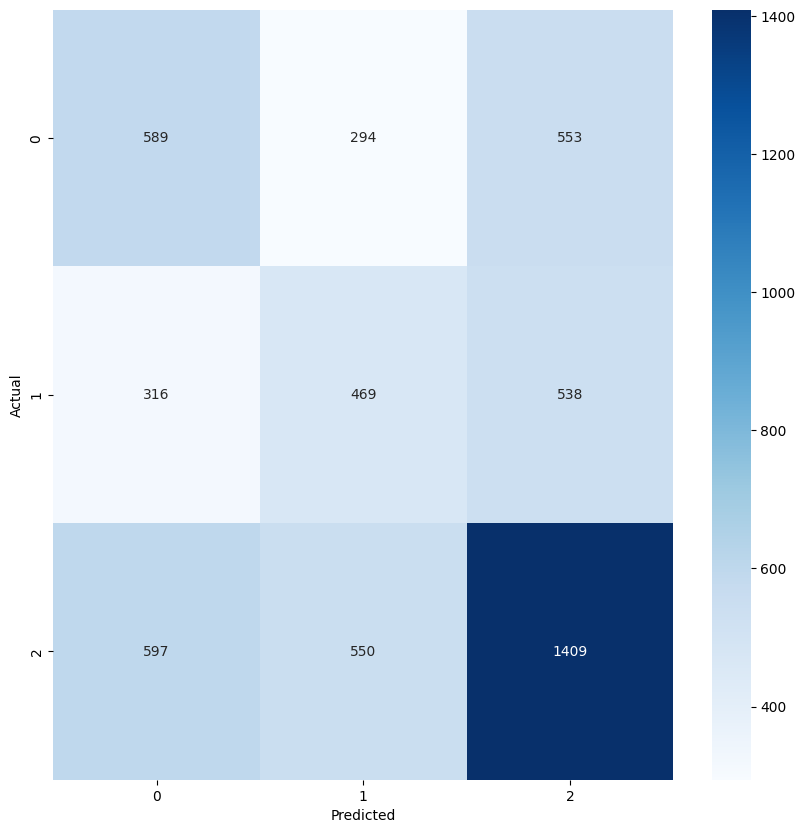

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_rf = rf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average='weighted')
recall = recall_score(y_test, y_pred_rf, average='weighted')
f1 = f1_score(y_test, y_pred_rf, average='weighted')

In [ ]:
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}")

Accuracy: 0.5924741298212606, Precision: 0.5854096308949658, Recall: 0.5924741298212606, F1-score: 0.5842680131380334


In [ ]:
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.5924741298212606
                 precision    recall  f1-score   support

     Exonerated       0.54      0.53      0.54      1436
  Substantiated       0.54      0.39      0.45      1323
Unsubstantiated       0.63      0.73      0.68      2556

       accuracy                           0.59      5315
      macro avg       0.57      0.55      0.56      5315
   weighted avg       0.59      0.59      0.58      5315

[[ 759  192  485]
 [ 205  518  600]
 [ 433  251 1872]]


In [ ]:
feature_importance = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importance)

                       importance
allegation               0.157432
command_now              0.130981
mos_age_incident         0.114112
precinct                 0.111817
command_at_incident      0.111099
month_received           0.100865
contact_reason           0.087414
rank_abbrev_now          0.054490
complainant_ethnicity    0.046241
fado_type                0.044018
rank_abbrev_incident     0.026036
complainant_gender       0.015494


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

In [ ]:
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}")

Accuracy: 0.5702728127939793, Precision: 0.5609981687121358, Recall: 0.5702728127939793, F1-score: 0.5597896055207464


In [ ]:
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.5702728127939793
                 precision    recall  f1-score   support

     Exonerated       0.52      0.53      0.53      1436
  Substantiated       0.50      0.33      0.40      1323
Unsubstantiated       0.62      0.72      0.66      2556

       accuracy                           0.57      5315
      macro avg       0.55      0.53      0.53      5315
   weighted avg       0.56      0.57      0.56      5315

[[ 762  204  470]
 [ 211  441  671]
 [ 487  241 1828]]


In [ ]:
feature_importances = model.feature_importances_
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances}).sort_values('Importance', ascending=False)
print(importances_df)

                  Feature  Importance
3              allegation    0.609379
2               fado_type    0.188420
6          contact_reason    0.040263
11        rank_abbrev_now    0.032745
9     command_at_incident    0.029536
1                precinct    0.029321
8             command_now    0.022944
10   rank_abbrev_incident    0.013304
7          month_received    0.010263
5      complainant_gender    0.009631
0        mos_age_incident    0.007332
4   complainant_ethnicity    0.006863


# **TARGET VARIABLE: SEVERITY**

### The focus of this proplem is to find how severe a particular complaint is .


It was calculated on the basis of outcome description of our dataset. As a particular outcome of a complaint can indicate the severity of the dataset. Once the model is trained, it also tells which variable highly inflences the severity of the problem, on the basis of which an outcome can also be predicted.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
for column in ['year_received','command_now','month_received','fado_type', 'allegation', 'precinct', 'complainant_ethnicity', 'complainant_gender','contact_reason','command_at_incident',
       'rank_abbrev_incident', 'rank_abbrev_now']:
    df[column] = LabelEncoder().fit_transform(df[column].astype(str))

X = df[['mos_age_incident', 'precinct', 'fado_type', 'allegation','complainant_ethnicity', 'complainant_gender','contact_reason','month_received','command_now','command_at_incident',
       'rank_abbrev_incident', 'rank_abbrev_now']]
y = LabelEncoder().fit_transform(df['severity_level'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Random Forest Classifier
Here, we will find the severity of the problem complained, and find the most significant variable for our analysis.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

feature_importance = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importance)


Accuracy: 0.7296331138287865
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      2229
           1       0.86      0.39      0.54       727
           2       0.72      0.79      0.75      2211
           3       0.91      0.28      0.42       148

    accuracy                           0.73      5315
   macro avg       0.80      0.57      0.62      5315
weighted avg       0.74      0.73      0.72      5315

                       importance
command_now              0.140914
precinct                 0.119552
command_at_incident      0.118880
mos_age_incident         0.118454
month_received           0.111318
contact_reason           0.092253
allegation               0.088601
rank_abbrev_now          0.065878
fado_type                0.052443
complainant_ethnicity    0.047886
rank_abbrev_incident     0.023293
complainant_gender       0.020529


In [ ]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.3, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

feature_importance = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importance)

Accuracy: 0.6291627469426152
              precision    recall  f1-score   support

           0       0.61      0.79      0.68      2229
           1       0.70      0.14      0.23       727
           2       0.66      0.67      0.66      2211
           3       0.52      0.08      0.14       148

    accuracy                           0.63      5315
   macro avg       0.62      0.42      0.43      5315
weighted avg       0.64      0.63      0.60      5315

                       importance
fado_type                0.244398
allegation               0.178969
contact_reason           0.172756
command_now              0.078373
command_at_incident      0.074600
precinct                 0.065570
mos_age_incident         0.053744
month_received           0.046959
rank_abbrev_incident     0.029649
rank_abbrev_now          0.026966
complainant_ethnicity    0.019946
complainant_gender       0.008069


In [ ]:
from xgboost import XGBClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

feature_importance = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importance)


Accuracy: 0.716650987770461
              precision    recall  f1-score   support

           0       0.70      0.82      0.75      2229
           1       0.80      0.36      0.50       727
           2       0.72      0.76      0.74      2211
           3       0.88      0.25      0.39       148

    accuracy                           0.72      5315
   macro avg       0.78      0.55      0.60      5315
weighted avg       0.73      0.72      0.70      5315

                       importance
fado_type                0.413830
allegation               0.095521
contact_reason           0.063468
rank_abbrev_incident     0.058691
command_at_incident      0.051839
precinct                 0.046975
command_now              0.046884
complainant_ethnicity    0.045821
rank_abbrev_now          0.044769
month_received           0.044259
complainant_gender       0.044037
mos_age_incident         0.043905


# **Target Variable: RESOLUTION CATEGORY**

#### This analysis segment aims to predict the resolution category of complaints by examining the duration required to resolve each complaint. The resolution times are segmented into four quartiles using percentile calculations (0%, 25%, 50%, 75%, 100%), which effectively categorize resolution durations into four distinct groups. These groups are labeled from 'Range_1' to 'Range_4', each representing a different range of resolution times.





In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

percentiles = np.percentile(df['days_taken_to_resolve'].dropna(), [0, 25, 50, 75, 100])
categories = ['Range_1', 'Range_2', 'Range_3', 'Range_4']

df['days_taken_to_resolve'] = df['days_taken_to_resolve'].fillna(df['days_taken_to_resolve'].median())

df['resolution_category'] = pd.cut(df['days_taken_to_resolve'], bins=percentiles, labels=categories, include_lowest=True)

X = df_encoding_scaled.drop(columns=['days_taken_to_resolve', 'year_received', 'month_closed', 'year_closed','case_count'], axis=1)
y = LabelEncoder().fit_transform(df['resolution_category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_model = RandomForestClassifier(n_estimators=100, random_state=42)
clf_model.fit(X_train, y_train)

y_pred = clf_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

scores = cross_val_score(clf_model, X, y, cv=5)
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

feature_importance = pd.DataFrame(clf_model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print("Features in decreasing importance:")
print(feature_importance)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1331
           1       0.78      0.79      0.78      1457
           2       0.87      0.76      0.81      1175
           3       0.78      0.84      0.81      1352

    accuracy                           0.80      5315
   macro avg       0.81      0.80      0.80      5315
weighted avg       0.81      0.80      0.80      5315

Accuracy: 0.8033866415804327
Precision: 0.8085619597174745
Recall: 0.8023024057680697
F1 Score: 0.804138999477596
Cross-validation scores: [0.28617121 0.2812794  0.3185924  0.3185924  0.30730147]
Average cross-validation score: 0.30238737483584954
Features in decreasing importance:
                                                   importance
unique_mos_id                                        0.052475
mos_age_incident                                     0.051592
month_received                                       0.048413
precinct   

# REGRESSION
## Target Variable: Bin Category('*resolved_in_bin*')

We perform binning to categorize the number of days taken to resolve into 6 bins and then perform classification to predict the bin category of the data. Methods of Ridge regression and Lasso regression are demonstrated below.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [ ]:
#Binning
num_bins = 6

df_original = df
df_original['resolved_in_bin'] = pd.qcut(df_original['days_taken_to_resolve'], q=num_bins, labels=False)

bin_boundaries = pd.qcut(df_original['days_taken_to_resolve'], q=num_bins).unique()
bin_boundaries_sorted = sorted(bin_boundaries)
bin_labels = [f"{bin_boundaries_sorted[i].left}-{bin_boundaries_sorted[i].right}" for i in range(len(bin_boundaries_sorted))]

df_original['range_for_bin'] = df_original['resolved_in_bin'].map(lambda x: bin_labels[x])
print(df_original['range_for_bin'])
unique_bins = sorted(df_original['resolved_in_bin'].unique())

for bin_label in unique_bins:
    bin_data = df_original[df_original['resolved_in_bin'] == bin_label]
    range_for_bin = bin_data['range_for_bin'].iloc[0]
    print(f"Bin {bin_label}: Range = {range_for_bin}")

0         304.0-365.0
1         304.0-365.0
2        27.999-153.0
3        27.999-153.0
4         153.0-242.0
             ...     
33304    27.999-153.0
33305    27.999-153.0
33306    27.999-153.0
33308     304.0-365.0
33309     304.0-365.0
Name: range_for_bin, Length: 26572, dtype: object
Bin 0: Range = 27.999-153.0
Bin 1: Range = 153.0-242.0
Bin 2: Range = 242.0-304.0
Bin 3: Range = 304.0-365.0
Bin 4: Range = 365.0-455.0
Bin 5: Range = 455.0-581.0


In [ ]:
X = df_encoding_scaled.drop('days_taken_to_resolve', axis=1)
Y = df_original['resolved_in_bin']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

RIDGE REGRESSION

In [ ]:
ridgeReg = Ridge(alpha=0.5)
ridgeReg.fit(X_train, y_train)

Ridge(alpha=0.5)

In [ ]:
y_pred_ridge=ridgeReg.predict(X_test)
y_pred_ridge_train=ridgeReg.predict(X_train)

In [ ]:
print(mean_squared_error(y_test, y_pred_ridge))
print(mean_squared_error(y_train, y_pred_ridge_train))
print(ridgeReg.score(X_test, y_test))

0.19651009622181417
0.18129256705605784
0.932602159343703


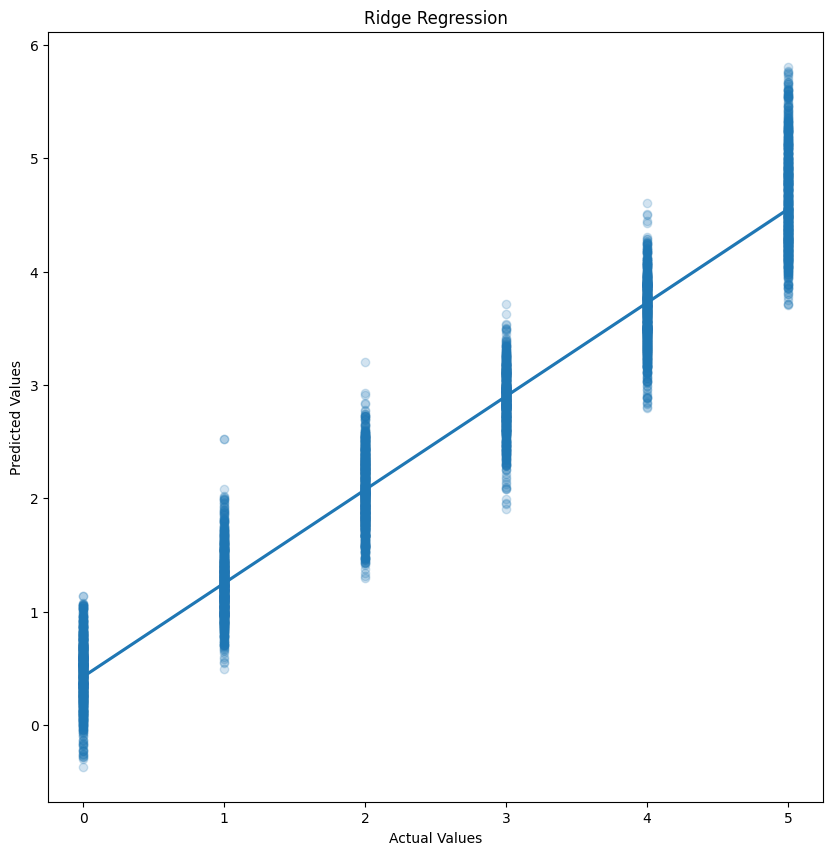

In [ ]:
sns.regplot(x=y_test, y=y_pred_ridge, scatter_kws={'alpha':0.2})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Ridge Regression')
plt.show()

LASSO

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_cv = LassoCV(alphas=[0.01, 0.1, 0.5, 1, 10], cv=5)
lasso_cv.fit(X_train_scaled, y_train)

y_pred_lasso_test = lasso_cv.predict(X_test_scaled)
y_pred_lasso_train = lasso_cv.predict(X_train_scaled)

print("Optimal alpha:", lasso_cv.alpha_)
print("Test MSE:", mean_squared_error(y_test, y_pred_lasso_test))
print("Train MSE:", mean_squared_error(y_train, y_pred_lasso_train))
print("Test Score (R²):", lasso_cv.score(X_test_scaled, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 432.54699433645146, tolerance: 4.964448338723903
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 432.4913691176271, tolerance: 4.954348156424601
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 433.3634228835135, tolerance: 4.9490268846289585
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceW

Optimal alpha: 0.01
Test MSE: 0.23544613779402726
Train MSE: 0.23001421233793545
Test Score (R²): 0.9192481120142016


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.361e+02, tolerance: 6.197e+00
  model = cd_fast.enet_coordinate_descent(


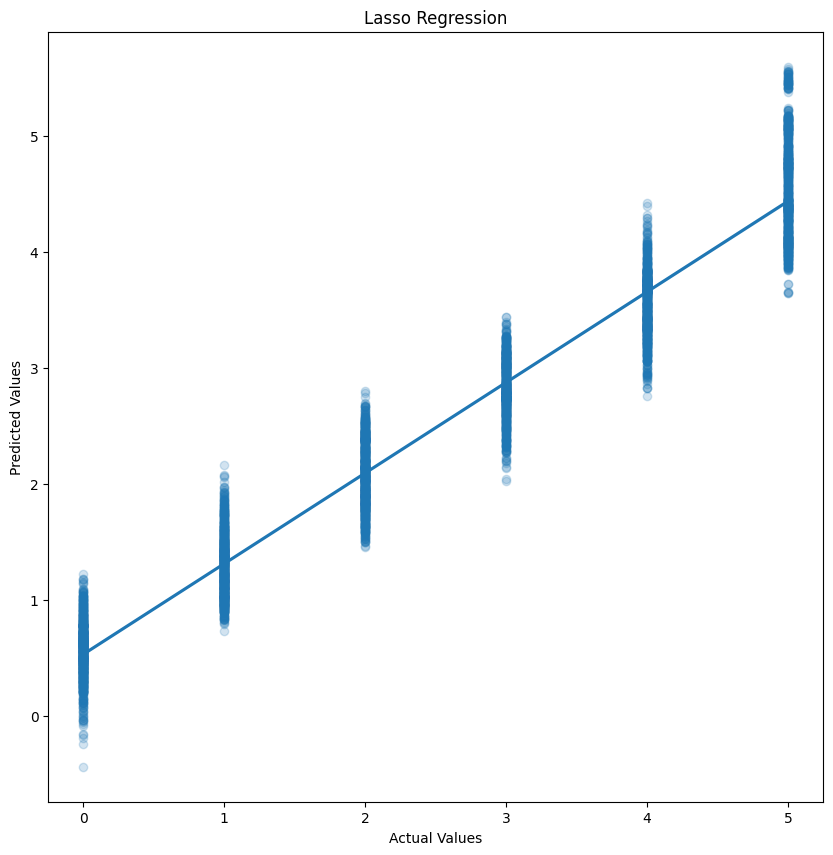

In [ ]:
sns.regplot(x=y_test, y=y_pred_lasso_test, scatter_kws={'alpha':0.2})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Lasso Regression')
plt.show()